# EATING POSTURE RECOGNITION OF FISH USING ACCELEROMETER SENSOR DATA

## Installing Dependencies

In [48]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy import fftpack
import math
from sklearn.datasets import make_classification

warnings.filterwarnings('ignore')


## Data Loading

In [2]:
def read_data(path):
    files = [file for file in os.listdir(path) if file.endswith('.xlsx')]
    dfs = []
    for file in files:
        file_path = os.path.join(path, file)
        pond_name = os.path.splitext(file)[0]
        df = pd.read_excel(file_path)
        df['pond_code'] = pond_name
        dfs.append(df)
    data = pd.concat(dfs, ignore_index=True)
    data['date'] = (data['timestamp']/1000).apply(datetime.fromtimestamp)
    data.sort_values(by=['pond_code', 'date'], inplace=True)
    return data

In [3]:
df = read_data('../data')
df.head()

timestamp   x    y   z  label pond_code                    date
8216  1657093314320   3  239  34      1       051 2022-07-06 14:41:54.320
8217  1657093314360   9  247  30      1       051 2022-07-06 14:41:54.360
8218  1657093314400   8  252  31      1       051 2022-07-06 14:41:54.400
8219  1657093314440   0  255  37      1       051 2022-07-06 14:41:54.440
8220  1657093314480 -12  252  39      1       051 2022-07-06 14:41:54.480

In [4]:
# some info about the data

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28392 entries, 8216 to 19967
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  28392 non-null  int64         
 1   x          28392 non-null  int64         
 2   y          28392 non-null  int64         
 3   z          28392 non-null  int64         
 4   label      28392 non-null  int64         
 5   pond_code  28392 non-null  object        
 6   date       28392 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(5), object(1)
memory usage: 1.7+ MB


## EDA}

<Axes: title={'center': 'Number of data points by pond'}>

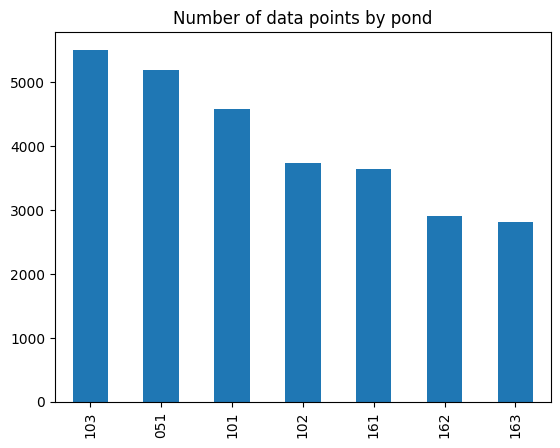

In [5]:
# count number endate by pond

df['pond_code'].value_counts().plot(kind='bar', title='Number of data points by pond')

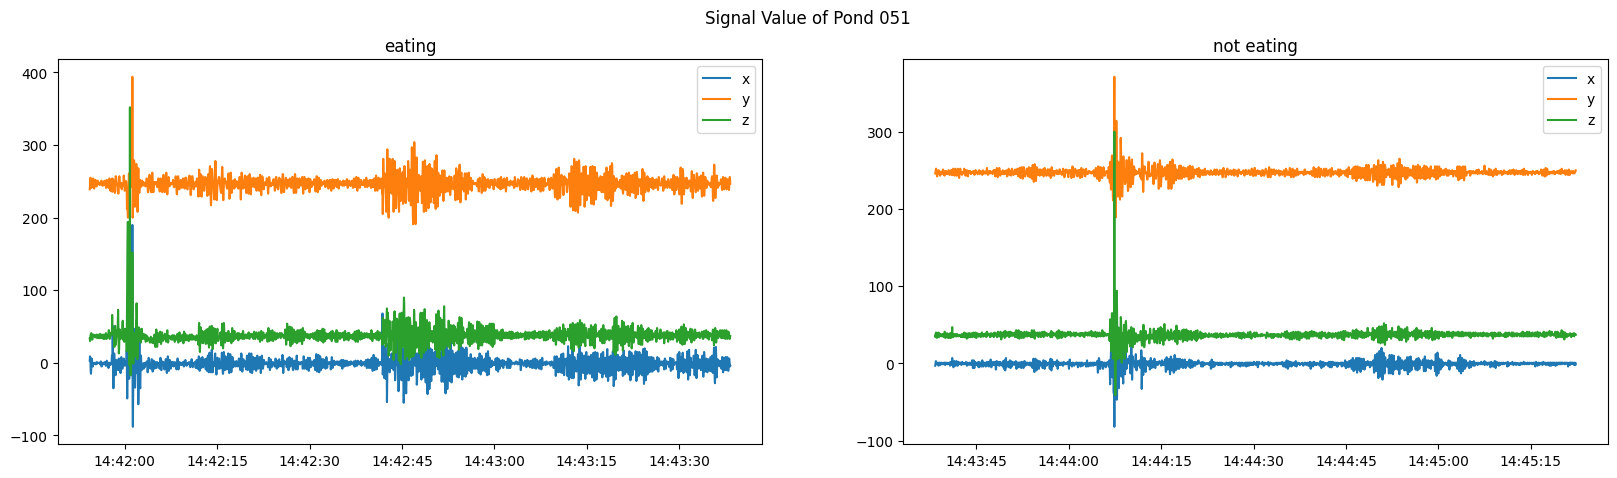

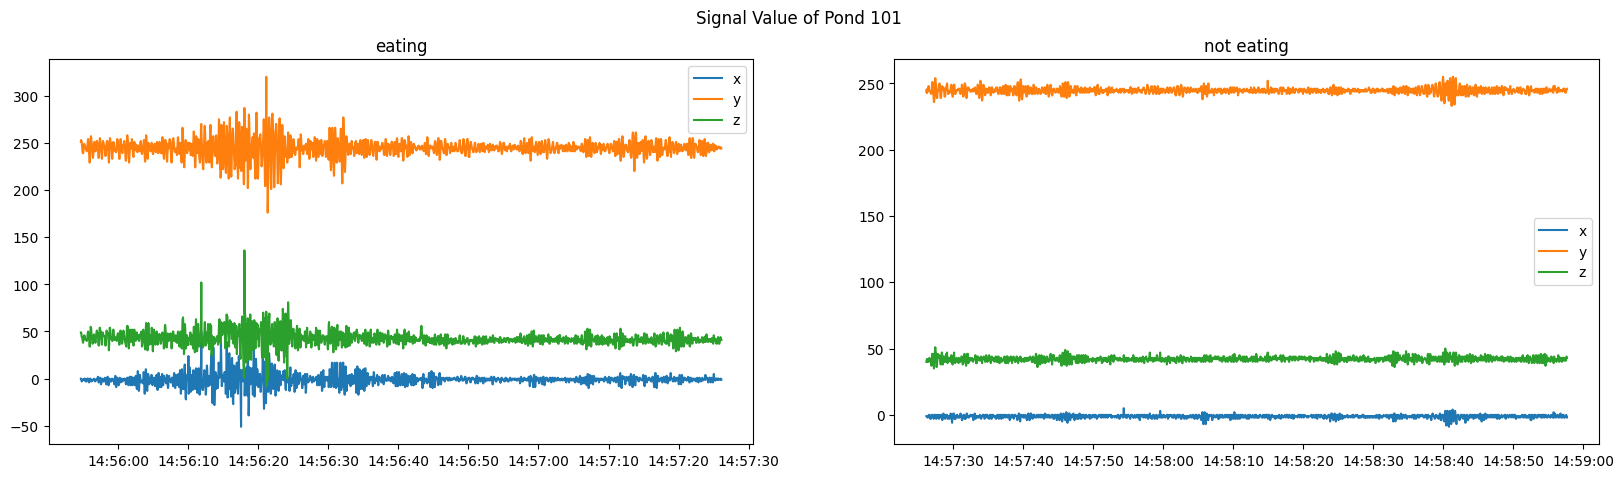

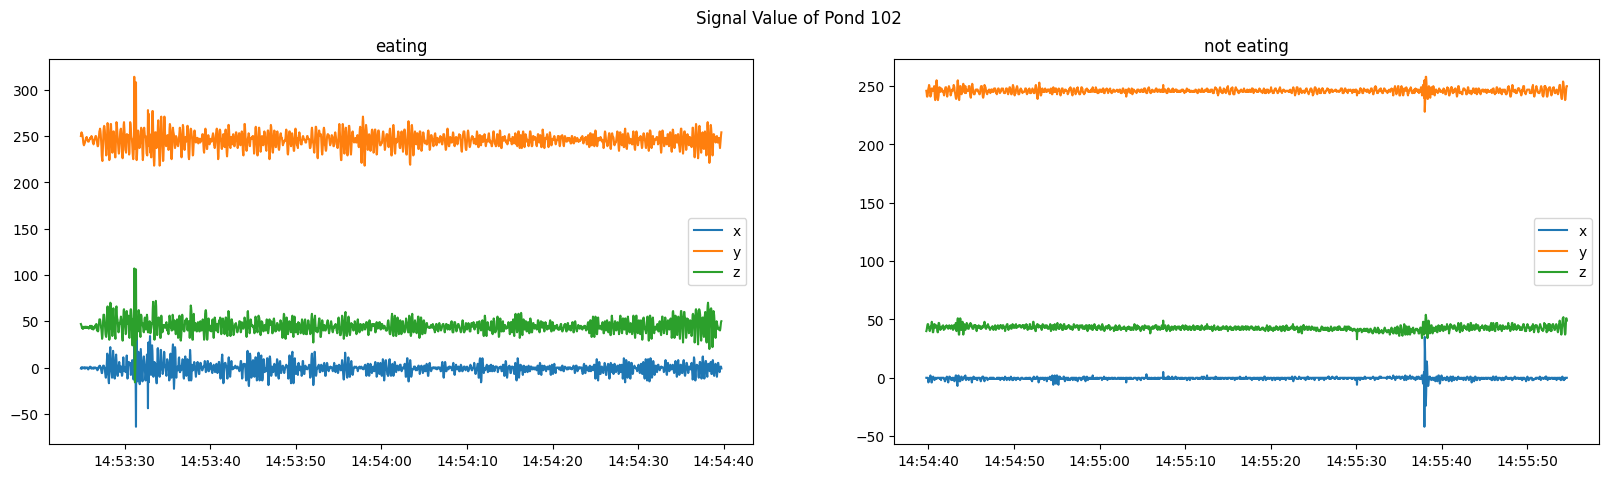

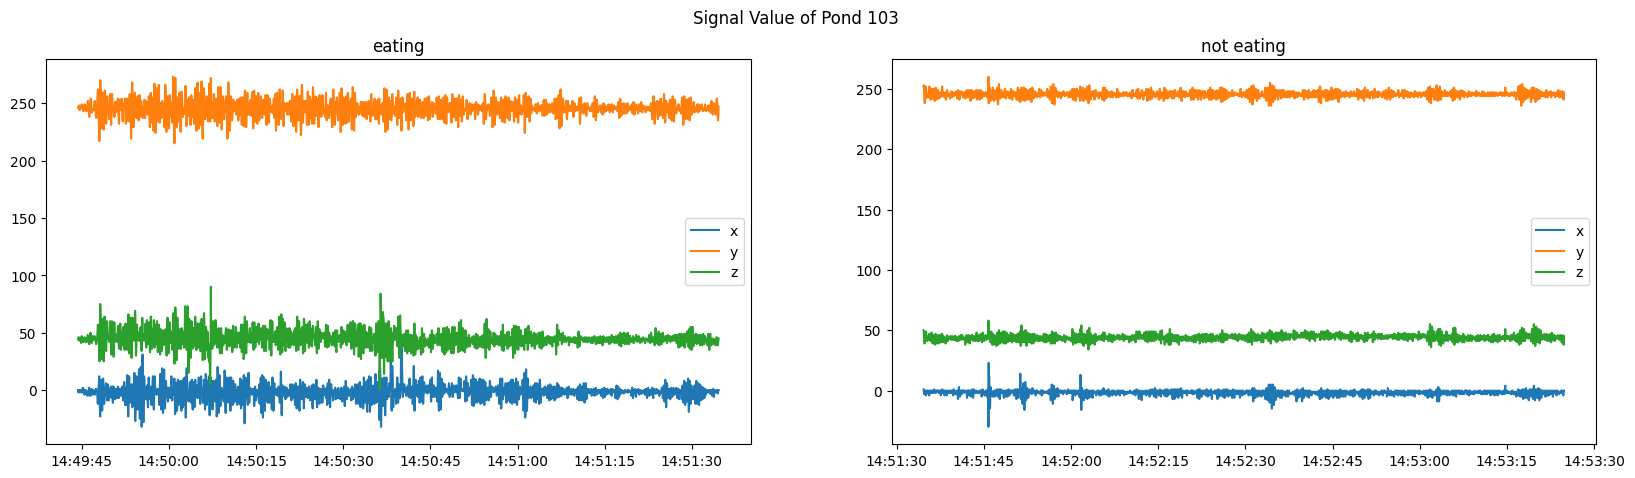

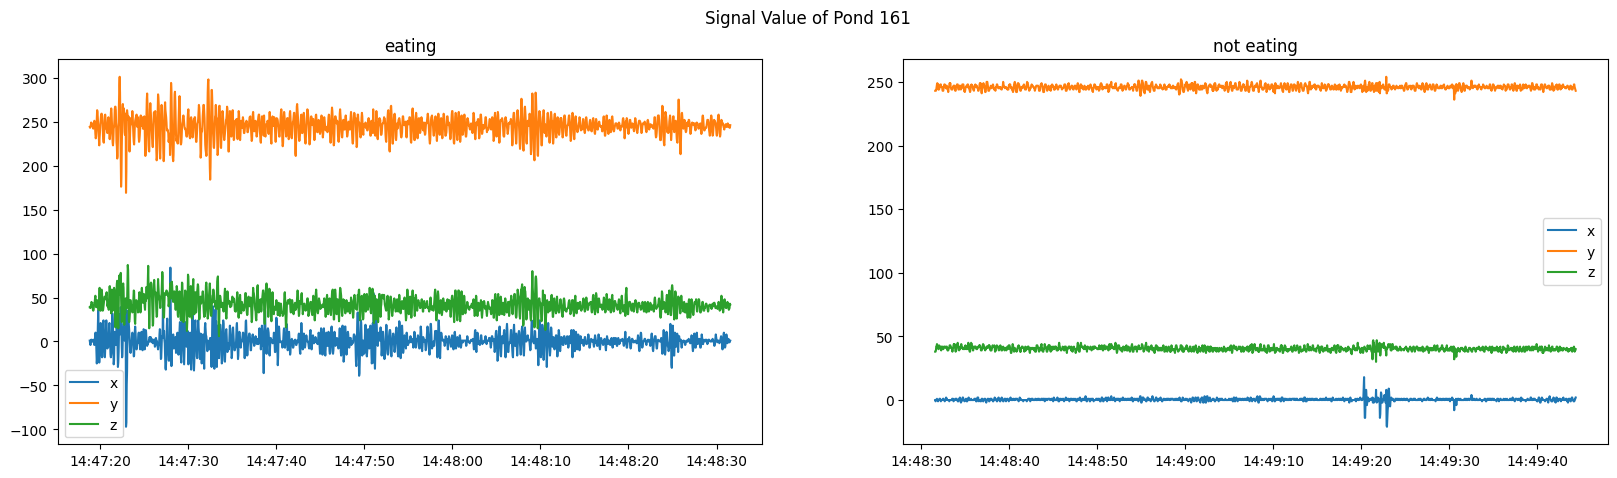

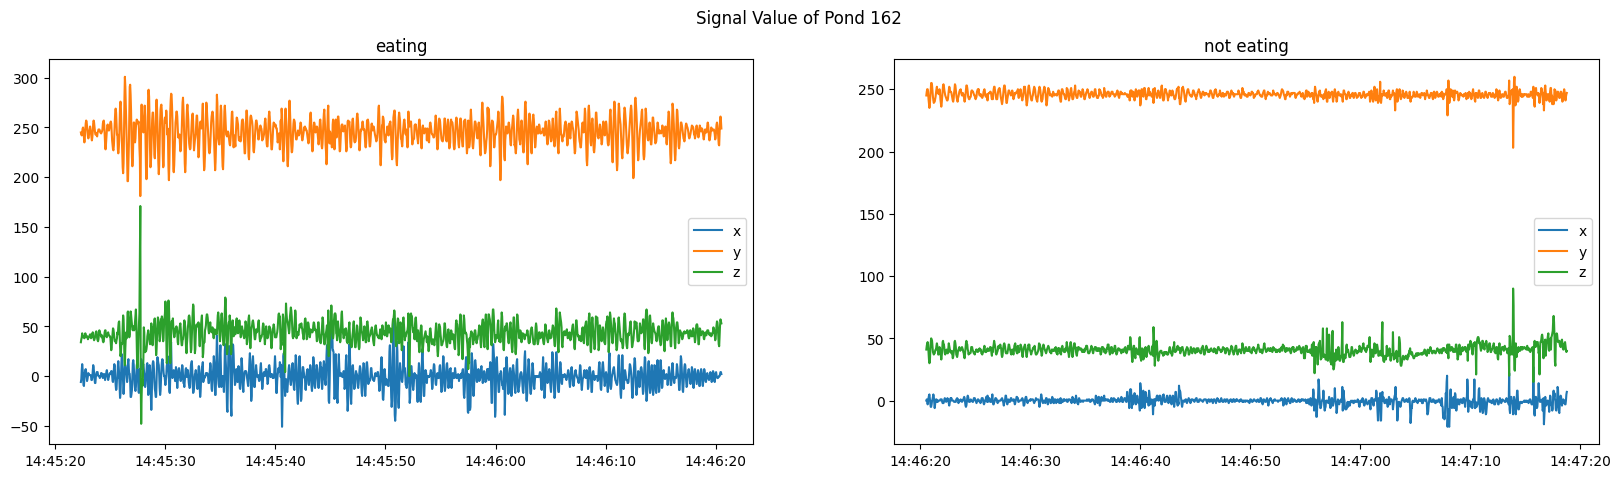

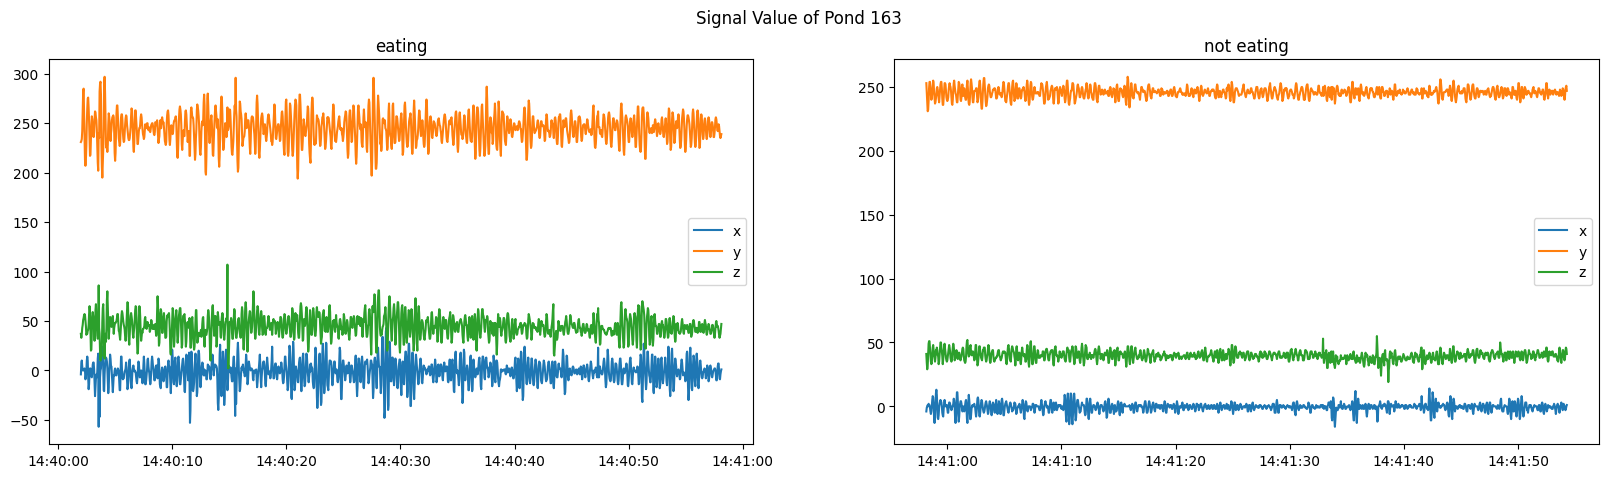

In [6]:
# signal by pond

ponds = df['pond_code'].unique()
for pond in ponds:
    pond_df = df[df['pond_code'] == pond]
    labels = pond_df['label'].unique()
    fig = plt.figure(figsize=(20, 5))
    for i, label in enumerate(labels):
        label_df = pond_df[pond_df['label'] == label]
        x = label_df['x']
        y = label_df['y']
        z = label_df['z']
        time = label_df['date']
        ax = fig.add_subplot(1, len(labels), i+1)
        ax.plot(time, x, label='x')
        ax.plot(time, y, label='y')
        ax.plot(time, z, label='z')
        if label == 0:
            ax.set_title("not eating")
        elif label == 1:
            ax.set_title("eating")
        ax.legend()
    fig.suptitle(f'Signal Value of Pond {pond}')
    # add suptitle
    plt.show()


In [7]:
print(df.date.min(), df.date.max())

2022-07-06 14:40:02 2022-07-06 14:58:57.640000


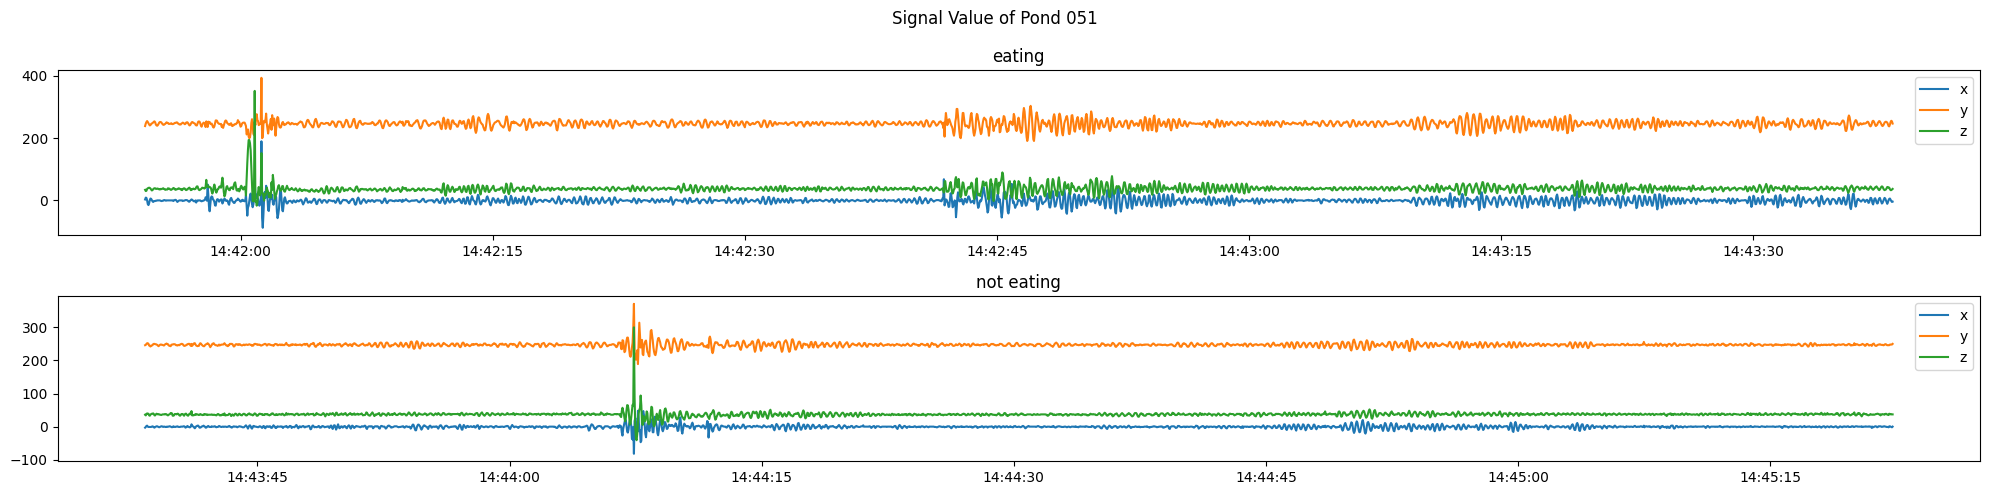

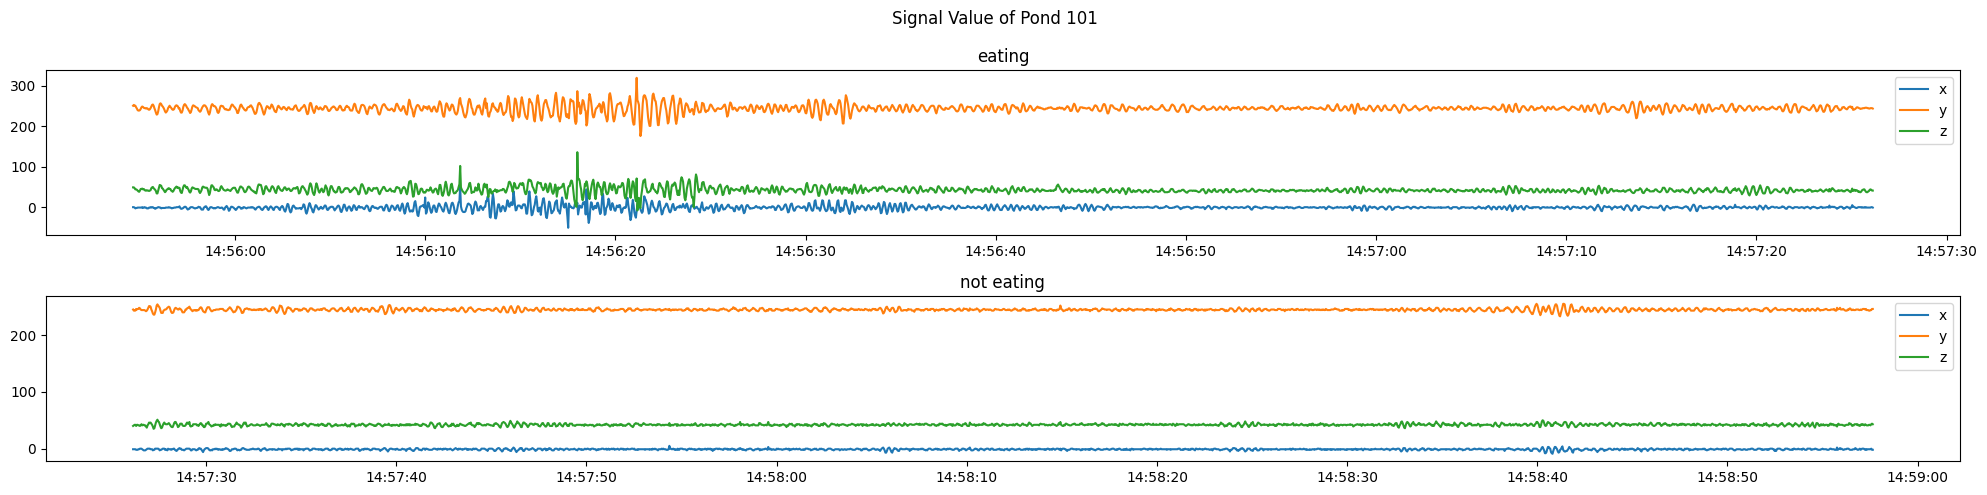

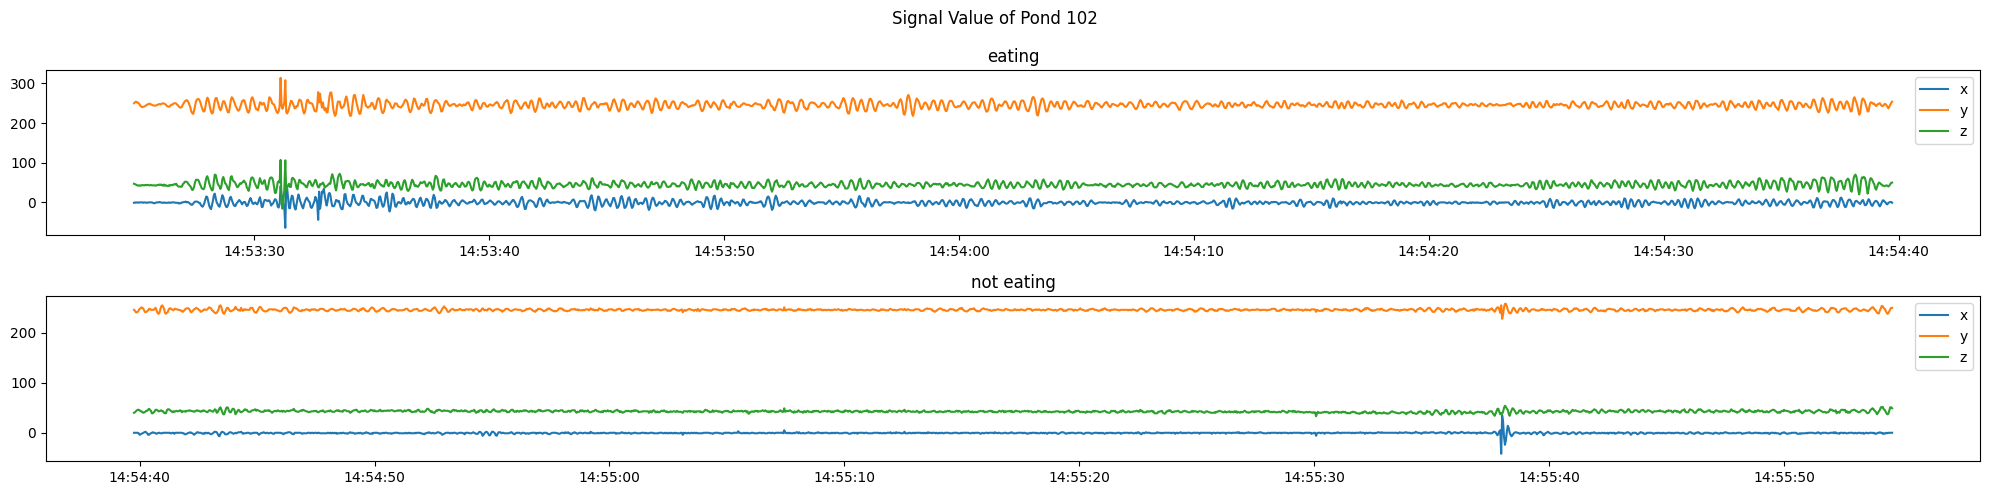

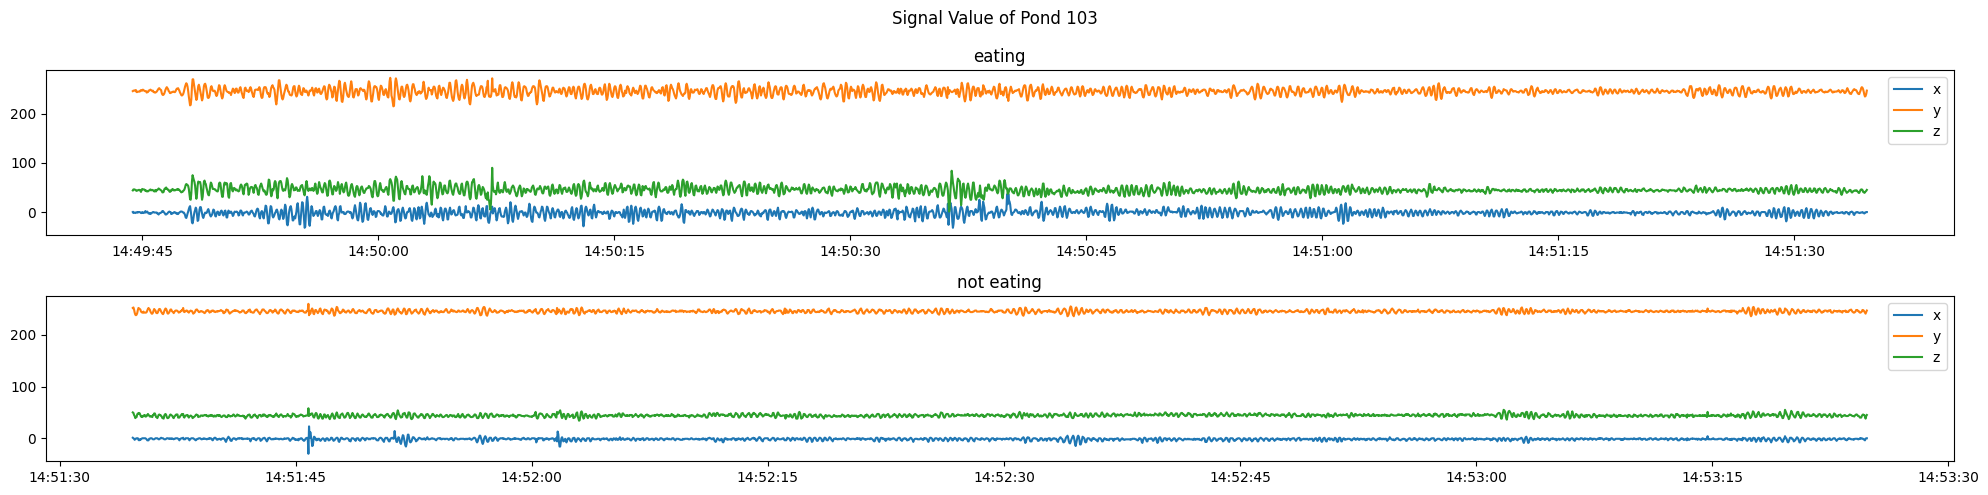

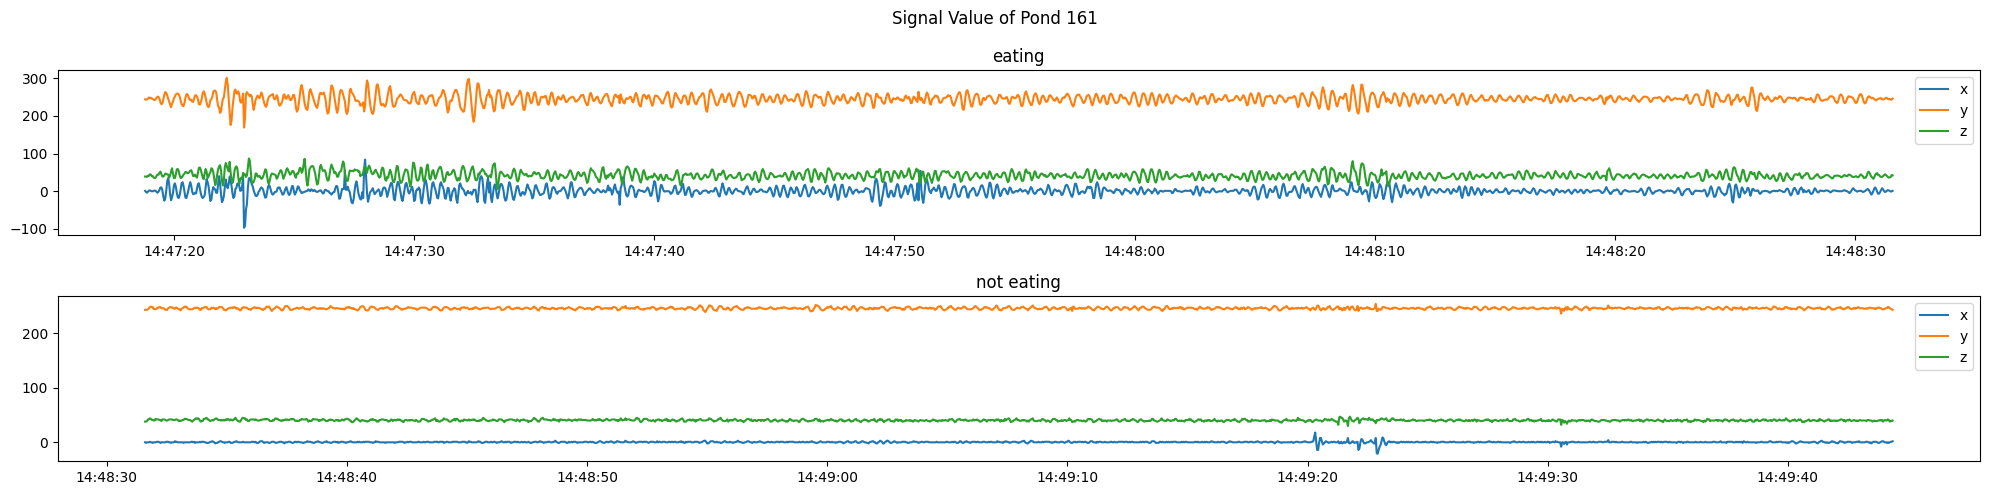

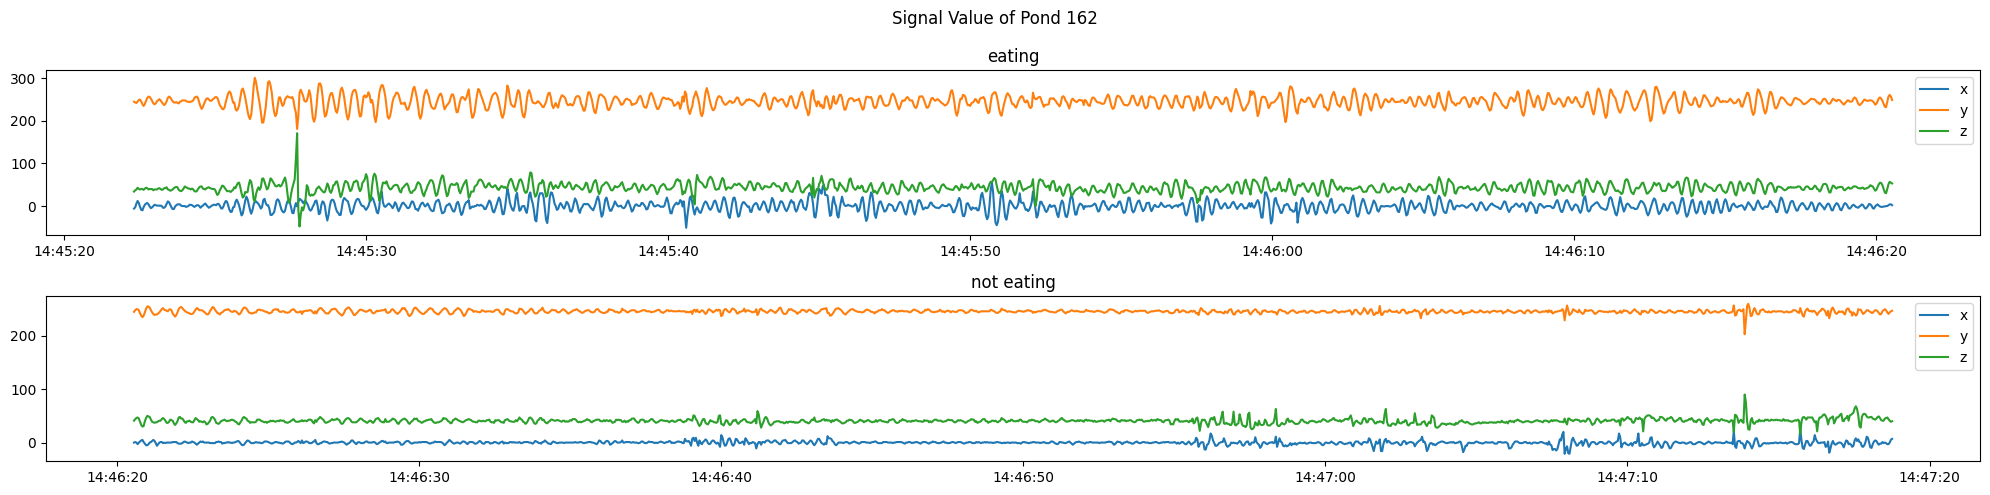

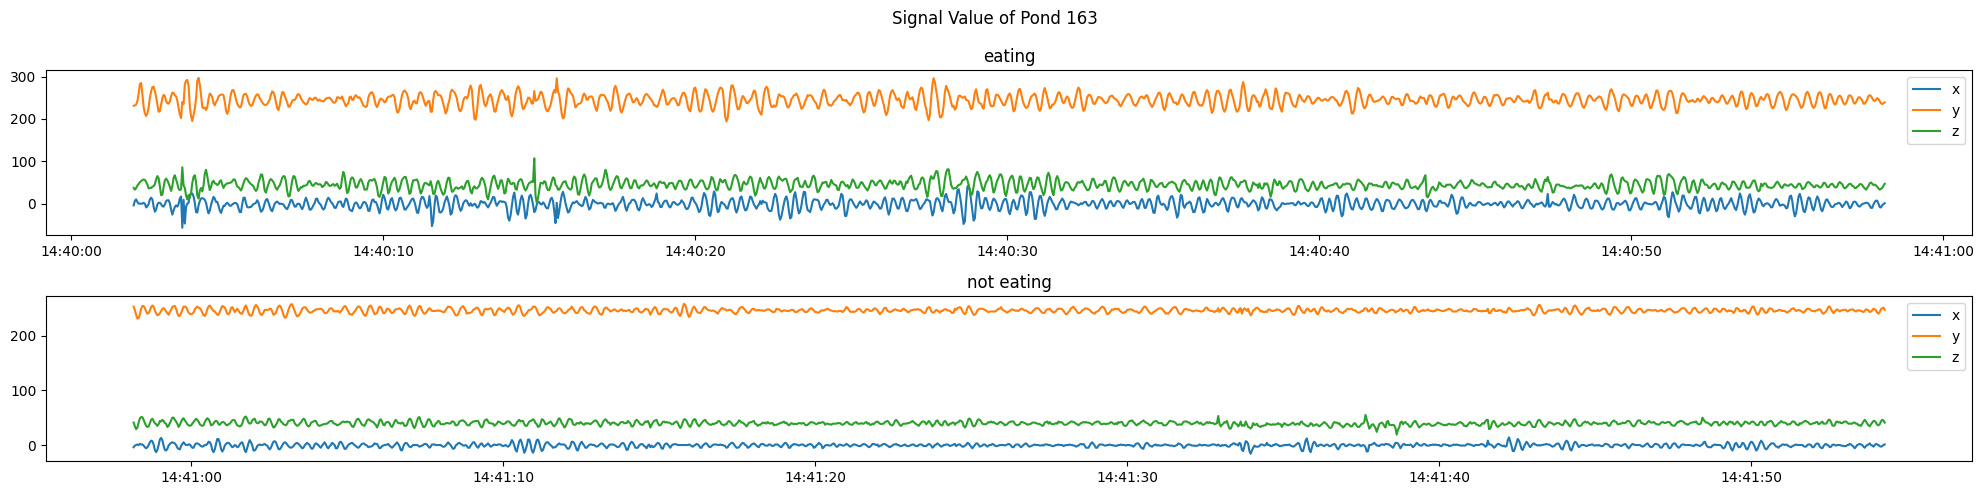

In [8]:
ponds = df['pond_code'].unique()
for pond in ponds:
    pond_df = df[df['pond_code'] == pond]
    labels = pond_df['label'].unique()
    fig = plt.figure(figsize=(20, 5))
    for i, label in enumerate(labels):
        label_df = pond_df[pond_df['label'] == label]
        x = label_df['x']
        y = label_df['y']
        z = label_df['z']
        time = label_df['date']
        ax = fig.add_subplot(len(labels), 1, i+1)
        ax.plot(time, x, label='x')
        ax.plot(time, y, label='y')
        ax.plot(time, z, label='z')
        if label == 0:
            ax.set_title("not eating")
        elif label == 1:
            ax.set_title("eating")
        ax.legend()
    fig.suptitle(f'Signal Value of Pond {pond}')
    plt.tight_layout()
    # add suptitle
    plt.show()

In [9]:
# eating duration by pond

groups = df.groupby(['pond_code', 'label']).agg({'date': lambda x: x.max() - x.min(), 
                                                'timestamp': lambda x: len(x)}).reset_index().rename(columns={'date': 'duration', 'timestamp': 'count'})
groups['duration'] = groups['duration'].apply(lambda x: x.seconds)
groups
                    

pond_code  label  duration  count
0        051      0       103   2600
1        051      1       103   2600
2        101      0        91   2288
3        101      1        91   2288
4        102      0        74   1872
5        102      1        74   1872
6        103      0       110   2756
7        103      1       110   2756
8        161      0        72   1820
9        161      1        72   1820
10       162      0        58   1456
11       162      1        58   1456
12       163      0        56   1404
13       163      1        56   1404

Text(0.5, 1.0, 'Duration of Eating and Not Eating by Pond')

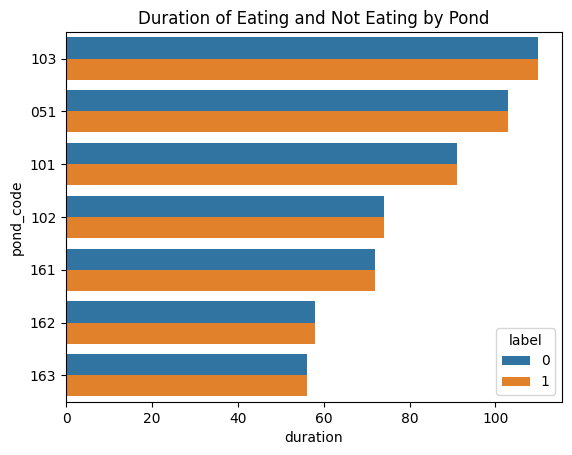

In [10]:
# bar plot of duration

sns.barplot(x='duration', y='pond_code', hue='label', data=groups.sort_values(by='duration', ascending=False))
plt.title('Duration of Eating and Not Eating by Pond')


In [13]:
# correlation matrix

corr = df[['x', 'y', 'z', 'label', 'pond_code']].corr()
corr

x         y         z     label
x      1.000000  0.001602  0.039605 -0.005180
y      0.001602  1.000000  0.186730 -0.026689
z      0.039605  0.186730  1.000000  0.110991
label -0.005180 -0.026689  0.110991  1.000000

In [11]:
#from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor

In [27]:
# # assume x, y, and z are sensor data and timestamps is an array of timestamps
# # convert timestamps to time differences
# time_diff = np.diff(df['timestamp'])

# # reshape sensor data to a 2D numpy array (samples x features)
# sensor_data = df[['x', 'y', 'z']].values.reshape(-1, 3)

# # extract features using TSFresh
# tsf_extractor = TSFreshFeatureExtractor(default_fc_parameters="minimal")
# X_features = tsf_extractor.fit_transform(sensor_data, y=None)

Feature Extraction: 100%|██████████| 3/3 [00:00<00:00, 125.90it/s]


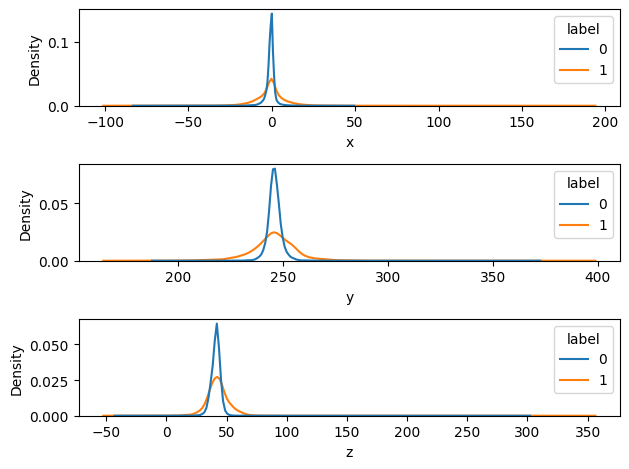

In [12]:
# kde plot of x, y, and z

fig, axes = plt.subplots(3, 1)
sns.kdeplot(data=df, x='x', hue='label', ax=axes[0])
sns.kdeplot(data=df, x='y', hue='label', ax=axes[1])
sns.kdeplot(data=df, x='z', hue='label', ax=axes[2])
plt.tight_layout()

In [29]:
# find at average x, y,z values for each pond that label is 1

df.groupby(['label','pond_code']).mean().reset_index()

label pond_code     timestamp         x           y          z
0       0       051  1.657093e+12 -0.487692  247.108462  36.940000
1       0       101  1.657094e+12 -1.175262  244.671329  42.108392
2       0       102  1.657094e+12 -0.481303  245.919338  42.688034
3       0       103  1.657094e+12 -1.729318  245.474964  44.144412
4       0       161  1.657094e+12  0.318681  245.796703  40.400000
5       0       162  1.657094e+12 -0.348901  245.710165  40.602335
6       0       163  1.657093e+12 -0.585470  245.736467  39.680912
7       1       051  1.657093e+12 -1.053846  246.580385  37.925000
8       1       101  1.657094e+12 -0.889860  244.466783  42.636801
9       1       102  1.657094e+12 -0.645833  245.634615  44.879274
10      1       103  1.657094e+12 -1.596517  245.358128  45.042090
11      1       161  1.657094e+12  0.561538  244.921429  42.282418
12      1       162  1.657094e+12 -0.182692  245.351648  43.419643
13      1       163  1.657093e+12 -1.252849  244.735755  44.620370

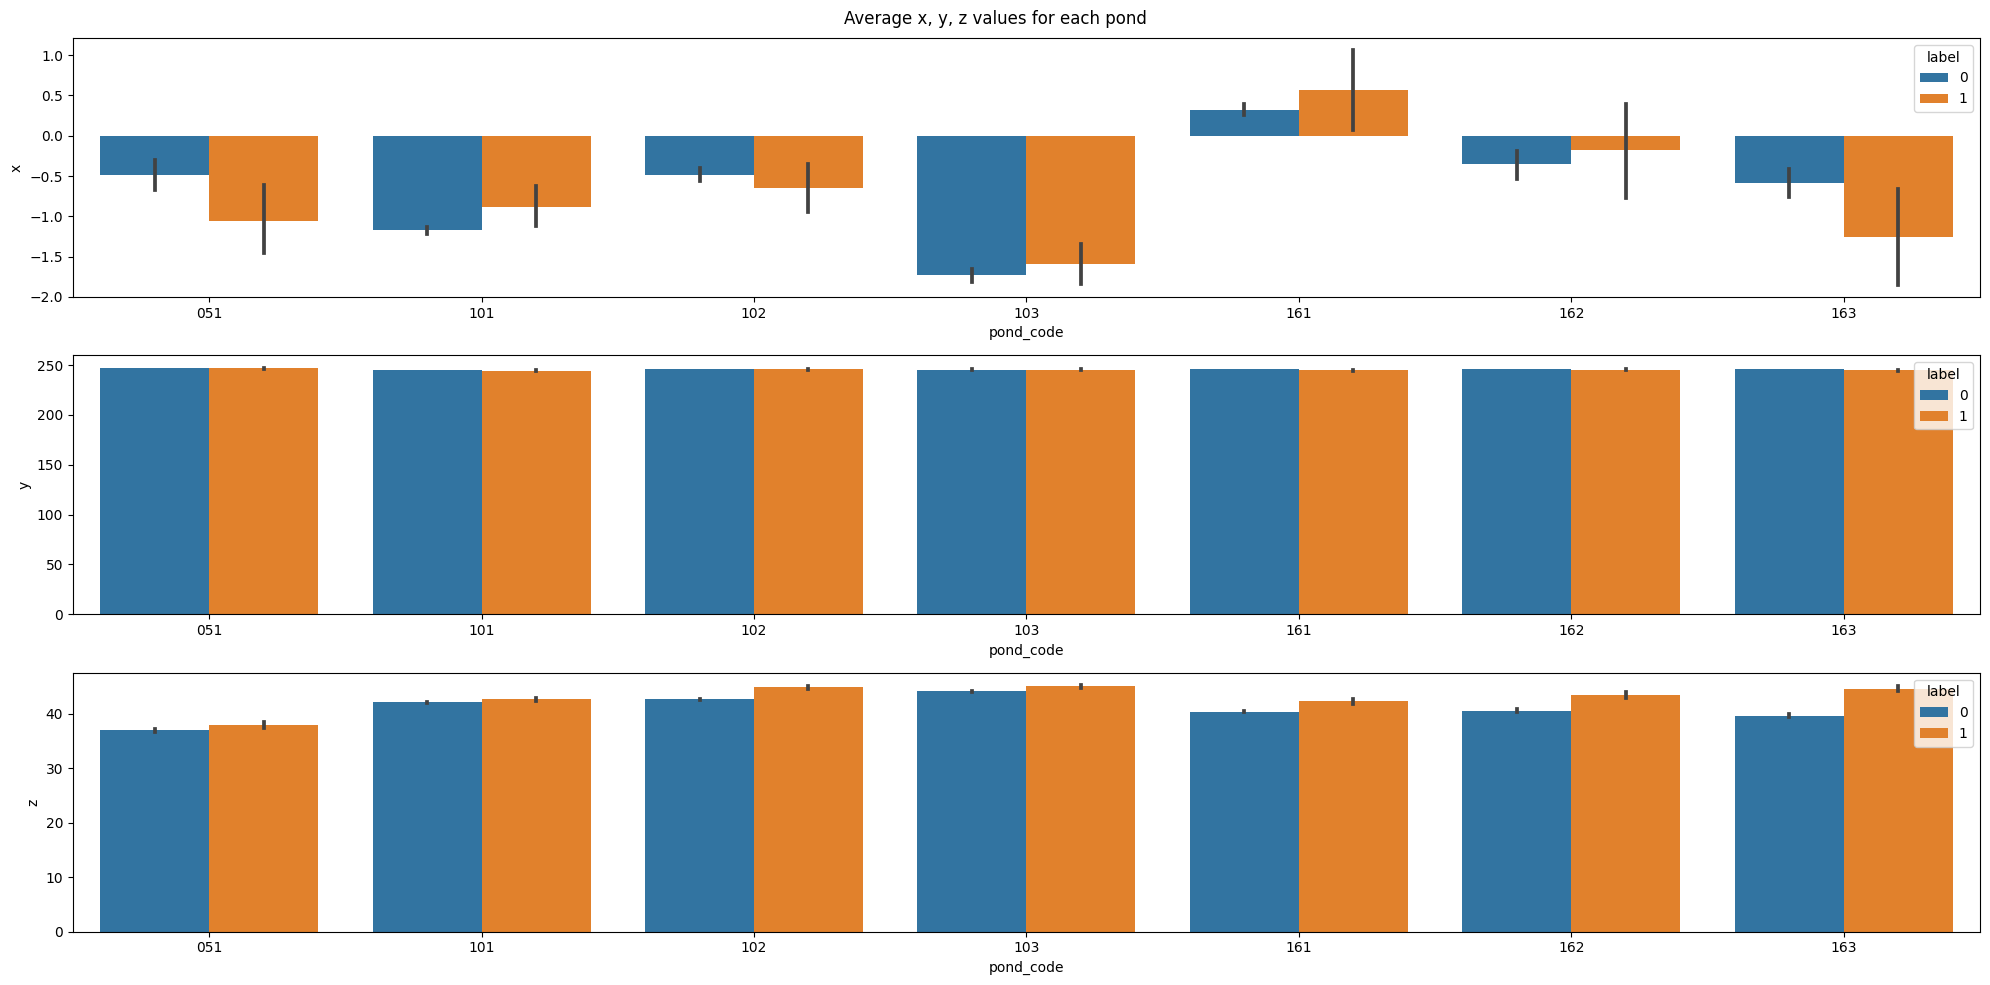

In [46]:
# plot of average x, y, z values for each pond 

fig, axes = plt.subplots(3, 1, figsize=(20, 10))
sns.barplot(x='pond_code', y='x', hue='label', data=df, ax=axes[0])
sns.barplot(x='pond_code', y='y', hue='label', data=df, ax=axes[1])
sns.barplot(x='pond_code', y='z', hue='label', data=df, ax=axes[2])
plt.suptitle('Average x, y, z values for each pond')
plt.tight_layout()

### Experiment 1
Use FFT transformation.

In [23]:
class TimeSeriesClassifier:
    def __init__(self):
        self.rf = RandomForestClassifier(n_estimators=100, random_state=42)
        self.xgb = XGBClassifier(n_estimators=100, random_state=42, learning_rate=0.1)
        self.sclf = StackingClassifier(
            estimators=[('rf', self.rf), ('xgb', self.xgb)],
            final_estimator=LogisticRegression()
        )

    def fit(self, X_train, y_train, model='rf'):
        if model == 'rf':
            self.rf.fit(X_train, y_train)
        elif model == 'xgb':
            self.xgb.fit(X_train, y_train)
        elif model == 'stacked':
            self.sclf.fit(X_train, y_train)
        else:
            raise ValueError("Invalid model type")

    def predict(self, X_test, model='rf'):
        if model == 'rf':
            y_pred = self.rf.predict(X_test)
        elif model == 'xgb':
            y_pred = self.xgb.predict(X_test)
        elif model == 'stacked':
            y_pred = self.sclf.predict(X_test)
        else:
            raise ValueError("Invalid model type")
        return y_pred

    def evaluate(self, X, y, model='rf'):
        if model == 'rf':
            clf = self.rf
        elif model == 'xgb':
            clf = self.xgb
        elif model == 'stacked':
            clf = self.sclf
        else:
            raise ValueError("Invalid model type")
        y_pred = clf.predict(X)
        cm = confusion_matrix(y, y_pred)
        print("Confusion Matrix:")
        print(cm)
        print("Classification Report:")
        print(classification_report(y, y_pred))
        print("ROC AUC Score:", roc_auc_score(y, y_pred))

    def plot_roc_curve(self, X, y, model='rf'):
        if model == 'rf':
            clf = self.rf
        elif model == 'xgb':
            clf = self.xgb
        elif model == 'stacked':
            clf = self.sclf
        else:
            raise ValueError("Invalid model type")
        y_score = clf.predict_proba(X)[:,1]
        fpr, tpr, _ = roc_curve(y, y_score)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(12,8))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()

In [15]:
df1 = df.copy()
df1.head()

timestamp   x    y   z  label pond_code                    date
8216  1657093314320   3  239  34      1       051 2022-07-06 14:41:54.320
8217  1657093314360   9  247  30      1       051 2022-07-06 14:41:54.360
8218  1657093314400   8  252  31      1       051 2022-07-06 14:41:54.400
8219  1657093314440   0  255  37      1       051 2022-07-06 14:41:54.440
8220  1657093314480 -12  252  39      1       051 2022-07-06 14:41:54.480

In [17]:
# assume x, y, and z are sensor data
# apply FFT to each sensor data column
x_fft = np.abs(fftpack.fft(df['x']))
y_fft = np.abs(fftpack.fft(df['y']))
z_fft = np.abs(fftpack.fft(df['z']))

# combine the FFT results into a feature matrix
X_fft = np.column_stack((x_fft, y_fft, z_fft))

In [18]:
# transform X_fft to a dataframe

X_fft = pd.DataFrame(X_fft, columns=['x_fft', 'y_fft', 'z_fft'])
X_fft['pond_code'] = df['pond_code']
X_fft = pd.get_dummies(X_fft, columns=['pond_code'], drop_first=True)
X_fft.head()

x_fft         y_fft         z_fft  pond_code_101  pond_code_102  \
0  21762.000000  6.972380e+06  1.189447e+06              0              0   
1   4851.226483  5.105968e+03  3.823577e+04              0              0   
2   6650.123876  7.004348e+03  1.582993e+04              0              0   
3   6697.805006  8.787696e+03  1.829889e+04              0              0   
4   2442.752315  4.075599e+03  8.669509e+03              0              0   

   pond_code_103  pond_code_161  pond_code_162  pond_code_163  
0              0              1              0              0  
1              0              1              0              0  
2              0              1              0              0  
3              0              1              0              0  
4              0              1              0              0

In [19]:
# split data into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X_fft, df['label'], test_size=0.3, random_state=42, stratify=df['label'])

### Model Fit and Evaluation

Model: rf
Confusion Matrix:
[[3061 1198]
 [1490 2769]]
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.72      0.69      4259
           1       0.70      0.65      0.67      4259

    accuracy                           0.68      8518
   macro avg       0.69      0.68      0.68      8518
weighted avg       0.69      0.68      0.68      8518

ROC AUC Score: 0.6844329654848557


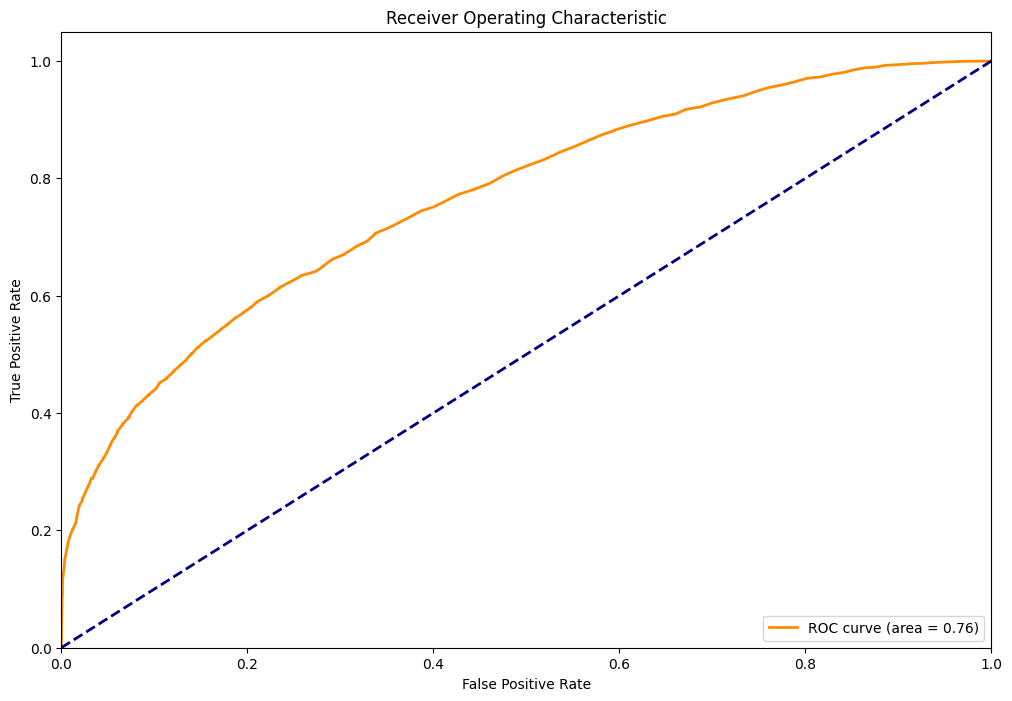

Model: xgb
Confusion Matrix:
[[3336  923]
 [1490 2769]]
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.78      0.73      4259
           1       0.75      0.65      0.70      4259

    accuracy                           0.72      8518
   macro avg       0.72      0.72      0.72      8518
weighted avg       0.72      0.72      0.72      8518

ROC AUC Score: 0.716717539328481


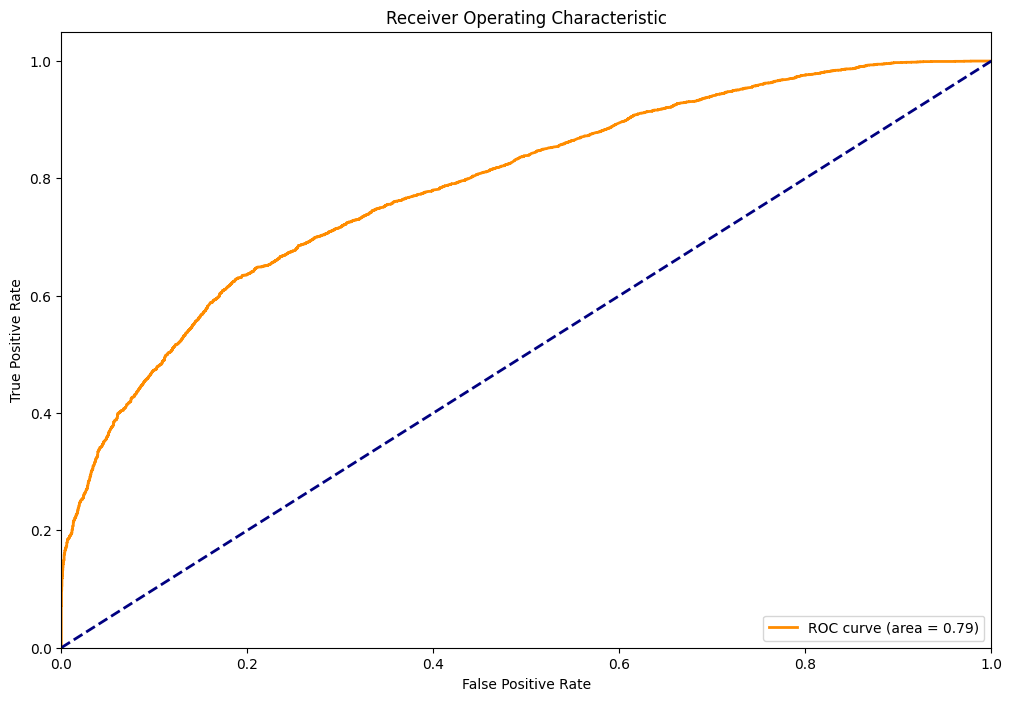

Model: stacked
Confusion Matrix:
[[3304  955]
 [1467 2792]]
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.78      0.73      4259
           1       0.75      0.66      0.70      4259

    accuracy                           0.72      8518
   macro avg       0.72      0.72      0.71      8518
weighted avg       0.72      0.72      0.71      8518

ROC AUC Score: 0.7156609532754167


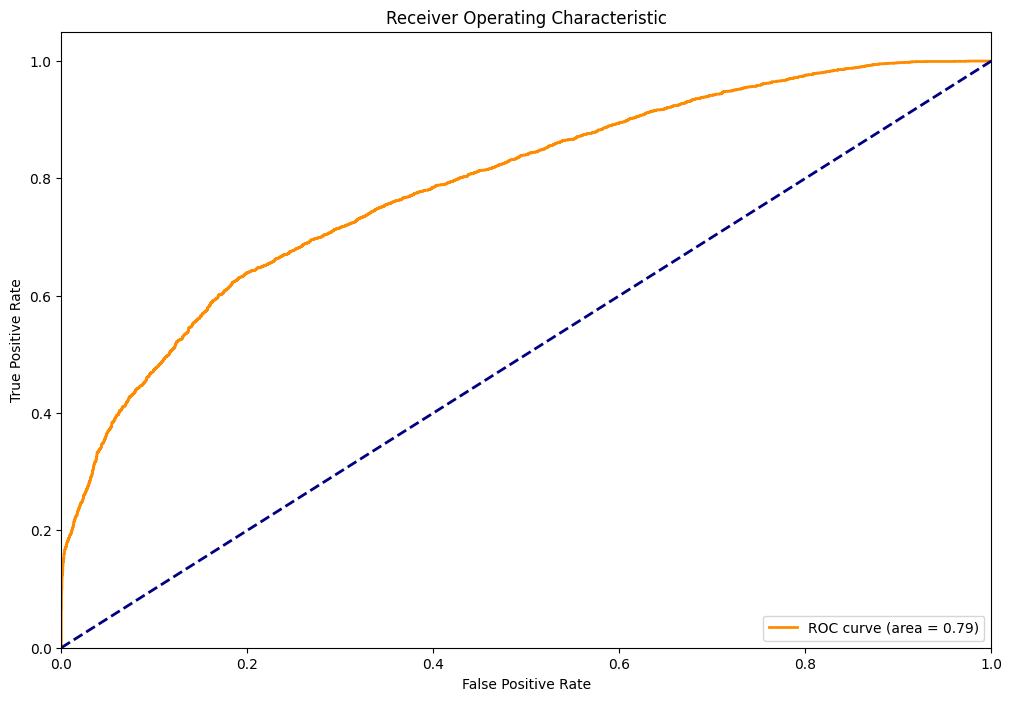

In [26]:
model_type = ['rf', 'xgb', 'stacked']
for model in model_type:
    print("Model:", model)
    clf = TimeSeriesClassifier()
    clf.fit(X_train, y_train, model=model)
    clf.evaluate(X_test, y_test, model=model)
    clf.plot_roc_curve(X_test, y_test, model=model)
    print("=====================================")

## Experiment 2
Use rolling window and lagging.

In [108]:
class FeaturePreprocessing:
    def __init__(self, window_size=5, lag_size=2):
        self.window_size = window_size
        self.lag_size = lag_size

    def preprocess(self, data):
        data = self._add_rolling_features(data)
        data = self._add_lag_features(data)
        data = self._one_hot_encode(data)
        # drop rows with NaN values
        data['magn'] = (data['x']**2 + data['y']**2 + data['z']**2).apply(lambda x: math.sqrt(x))
        data = data.dropna()

        # split data into train and test
        X = data.drop(columns=['label', 'date', 'timestamp','x','y','z'], axis=1)
        
        y = data['label']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
        # use 500 last rows for testing
        # X_train = X.iloc[:-500]
        # X_test = X.iloc[-500:]
        # y_train = y.iloc[:-500]
        # y_test = y.iloc[-500:]
        return X_train, X_test, y_train, y_test

    def _add_rolling_features(self, data):
        data['x_rolling_mean'] = data['x'].rolling(window=self.window_size).mean()
        data['x_rolling_std'] = data['x'].rolling(window=self.window_size).std()
        data['x_rolling_min'] = data['x'].rolling(window=self.window_size).min()
        data['x_rolling_max'] = data['x'].rolling(window=self.window_size).max()
        data['y_rolling_mean'] = data['y'].rolling(window=self.window_size).mean()
        data['y_rolling_std'] = data['y'].rolling(window=self.window_size).std()
        data['y_rolling_min'] = data['y'].rolling(window=self.window_size).min()
        data['y_rolling_max'] = data['y'].rolling(window=self.window_size).max()
        data['z_rolling_mean'] = data['z'].rolling(window=self.window_size).mean()
        data['z_rolling_std'] = data['z'].rolling(window=self.window_size).std()
        data['z_rolling_min'] = data['z'].rolling(window=self.window_size).min()
        data['z_rolling_max'] = data['z'].rolling(window=self.window_size).max()
        
        return data
    
    def _add_lag_features(self, data):
        for i in range(1, self.lag_size+1):
            data[f'x_lag_{i}'] = data['x'].shift(i)
            data[f'y_lag_{i}'] = data['y'].shift(i)
            data[f'z_lag_{i}'] = data['z'].shift(i)
        # data['x_lag'] = data['x'].shift(self.lag_size)
        # data['y_lag'] = data['y'].shift(self.lag_size)
        # data['z_lag'] = data['z'].shift(self.lag_size)
        return data

    def _one_hot_encode(self, data):
        #data['label'] = data['label'].astype('category')
        data = pd.get_dummies(data, columns=['pond_code'])
        return data

In [92]:
df2 = df.copy()
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28392 entries, 8216 to 19967
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  28392 non-null  int64         
 1   x          28392 non-null  int64         
 2   y          28392 non-null  int64         
 3   z          28392 non-null  int64         
 4   label      28392 non-null  int64         
 5   pond_code  28392 non-null  object        
 6   date       28392 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(5), object(1)
memory usage: 2.7+ MB


In [93]:
prep = FeaturePreprocessing(window_size=5, lag_size=10)

In [118]:
# define function to apply the feature preprocessing dataset per pond_id and concatenate the results

def preprocess_by_id(df2, window_size=5, lag_size=10):
    id = df2['pond_code'].unique()
    X_train_all = []
    X_test_all = []
    y_train_all = []
    y_test_all = []
    for i in id:
        df2 = df[df['pond_code'] == i]
        prep = FeaturePreprocessing(window_size=window_size, lag_size=lag_size)
        X_train, X_test, y_train, y_test = prep.preprocess(df2)
        X_train_all.append(X_train)
        X_test_all.append(X_test)
        y_train_all.append(y_train)
        y_test_all.append(y_test)
    X_train = pd.concat(X_train_all).fillna(0)
    X_test = pd.concat(X_test_all).fillna(0)
    y_train = pd.concat(y_train_all).fillna(0)
    y_test = pd.concat(y_test_all).fillna(0)
    return X_train, X_test, y_train, y_test

In [111]:
X_train3, X_test3, y_train3, y_test3 = preprocess_by_id(df2)

In [112]:
# print shape of the data

print(X_train3.shape, X_test3.shape, y_train3.shape, y_test3.shape)

(19823, 50) (8499, 50) (19823,) (8499,)


Model: rf
Confusion Matrix:
[[3760  501]
 [ 491 3747]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      4261
           1       0.88      0.88      0.88      4238

    accuracy                           0.88      8499
   macro avg       0.88      0.88      0.88      8499
weighted avg       0.88      0.88      0.88      8499

ROC AUC Score: 0.8832827152862773


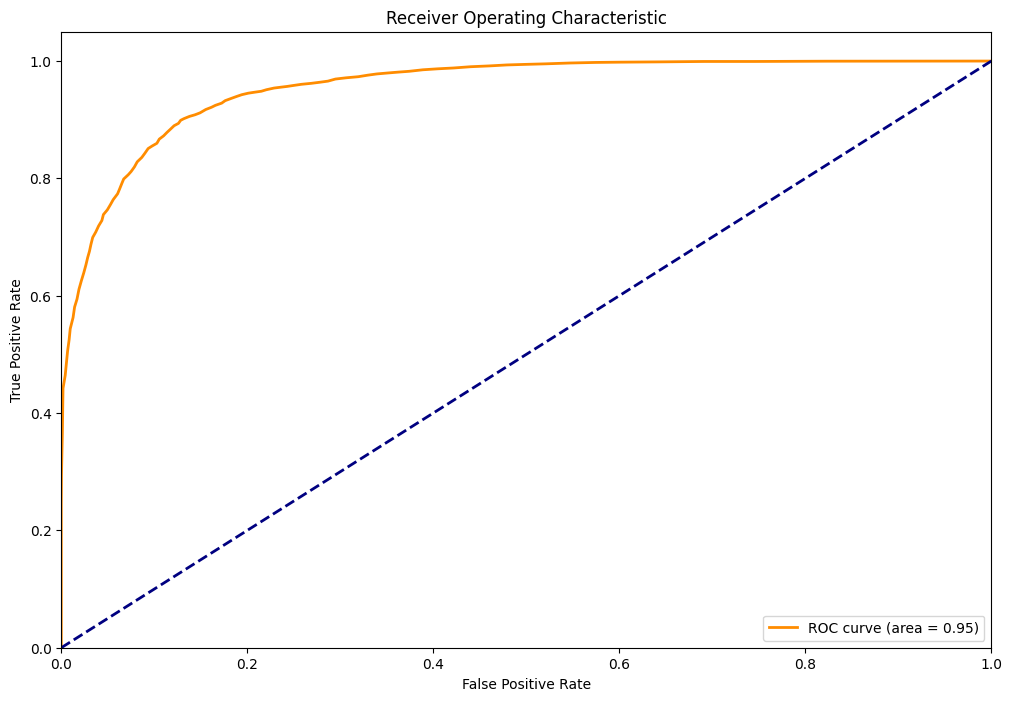

Model: xgb
Confusion Matrix:
[[3823  438]
 [ 590 3648]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.90      0.88      4261
           1       0.89      0.86      0.88      4238

    accuracy                           0.88      8499
   macro avg       0.88      0.88      0.88      8499
weighted avg       0.88      0.88      0.88      8499

ROC AUC Score: 0.8789953083704514


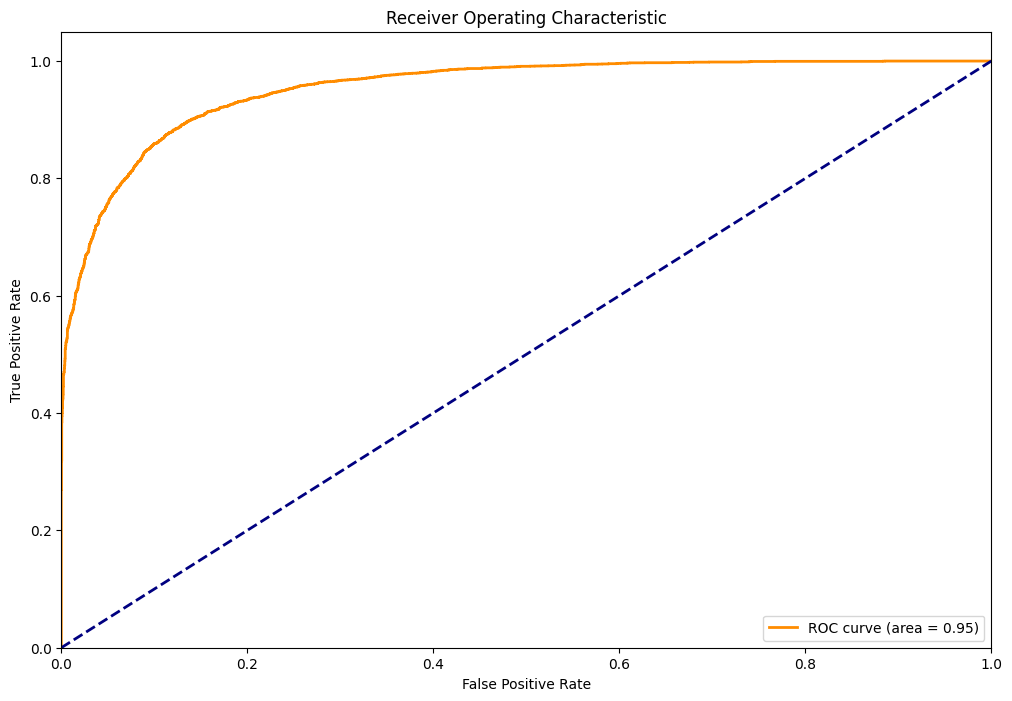

Model: stacked
Confusion Matrix:
[[3774  487]
 [ 516 3722]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.89      0.88      4261
           1       0.88      0.88      0.88      4238

    accuracy                           0.88      8499
   macro avg       0.88      0.88      0.88      8499
weighted avg       0.88      0.88      0.88      8499

ROC AUC Score: 0.881976017655882


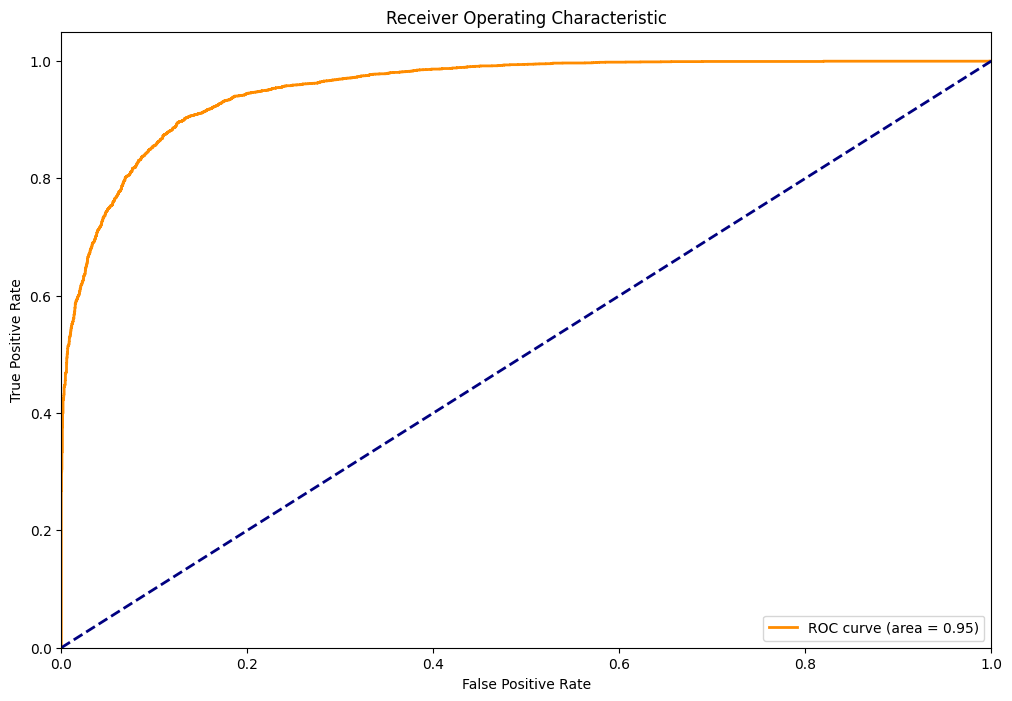

In [98]:
# print experiment results2

for model in model_type:
    print("Model:", model)
    clf = TimeSeriesClassifier()
    clf.fit(X_train3, y_train3, model=model)
    clf.evaluate(X_test3, y_test3, model=model)
    clf.plot_roc_curve(X_test3, y_test3, model=model)
    print("=====================================")

Model: rf
Confusion Matrix:
[[3756  505]
 [ 489 3749]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      4261
           1       0.88      0.88      0.88      4238

    accuracy                           0.88      8499
   macro avg       0.88      0.88      0.88      8499
weighted avg       0.88      0.88      0.88      8499

ROC AUC Score: 0.8830493022584082


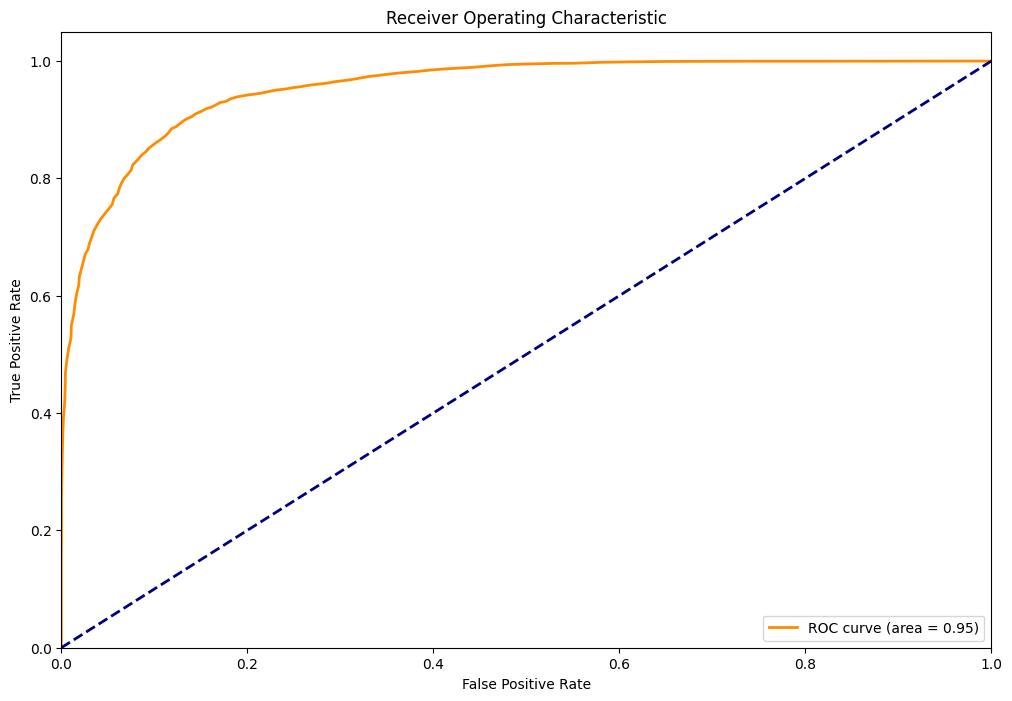

Model: xgb
Confusion Matrix:
[[3807  454]
 [ 584 3654]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      4261
           1       0.89      0.86      0.88      4238

    accuracy                           0.88      8499
   macro avg       0.88      0.88      0.88      8499
weighted avg       0.88      0.88      0.88      8499

ROC AUC Score: 0.8778256959003148


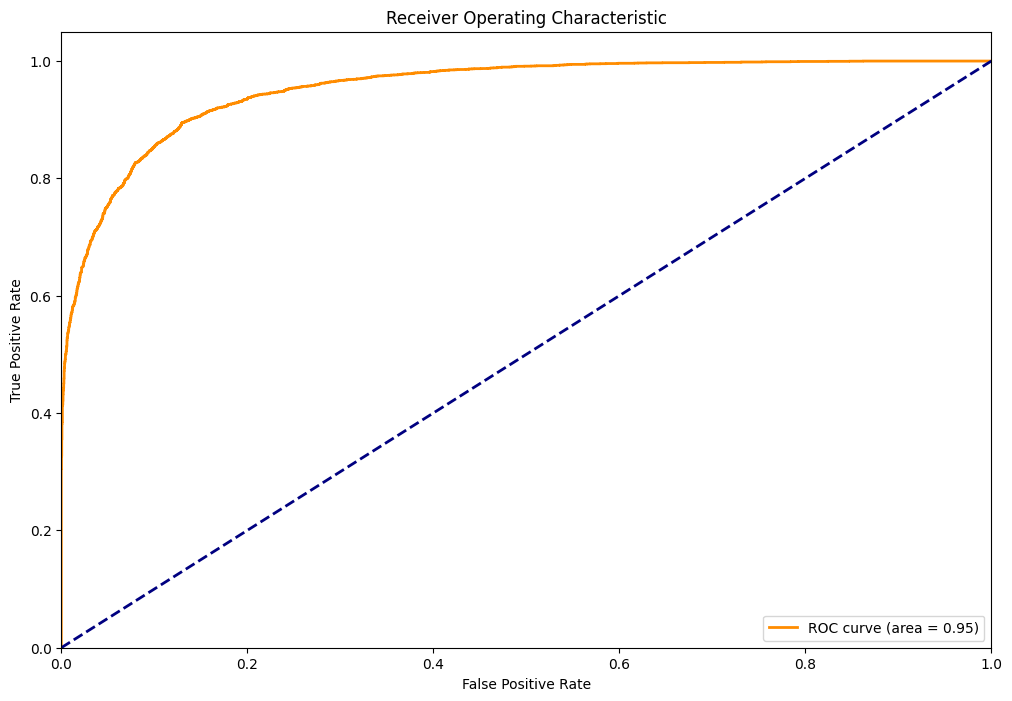

Model: stacked
Confusion Matrix:
[[3767  494]
 [ 515 3723]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      4261
           1       0.88      0.88      0.88      4238

    accuracy                           0.88      8499
   macro avg       0.88      0.88      0.88      8499
weighted avg       0.88      0.88      0.88      8499

ROC AUC Score: 0.8812725944087861


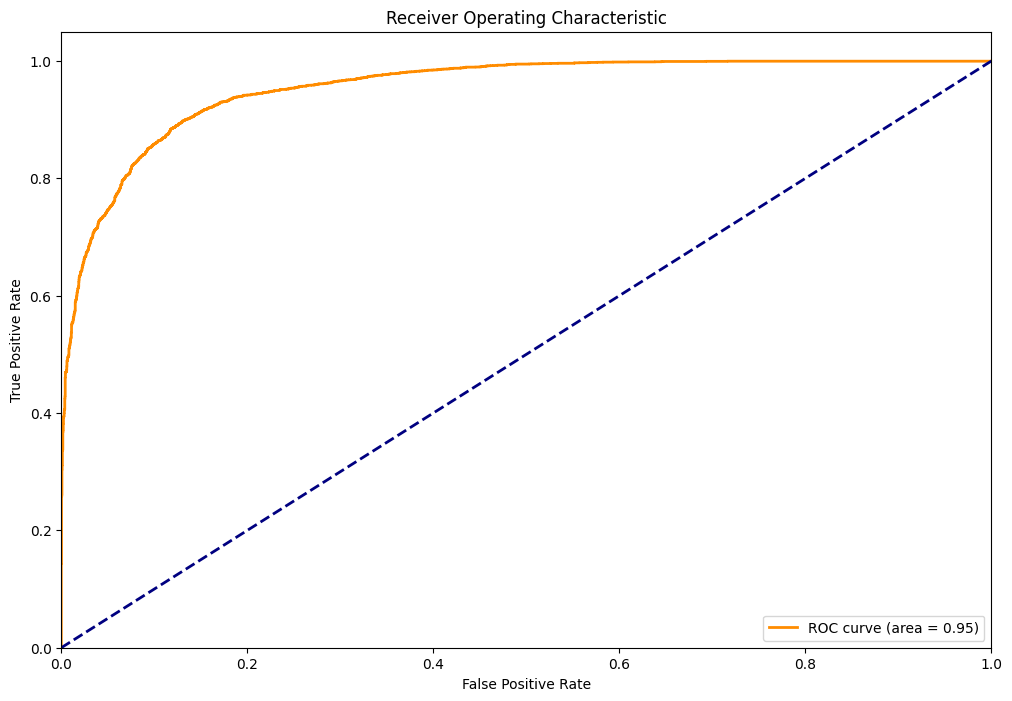

In [103]:
# print experiment results2

for model in model_type:
    print("Model:", model)
    clf = TimeSeriesClassifier()
    clf.fit(X_train3.iloc[:,:-1], y_train3, model=model)
    clf.evaluate(X_test3.iloc[:,:-1], y_test3, model=model)
    clf.plot_roc_curve(X_test3.iloc[:,:-1], y_test3, model=model)
    print("=====================================")

## Experiment 3

In [119]:
X_train4, X_test4, y_train4, y_test4 = preprocess_by_id(df2, window_size=5, lag_size=20)

In [120]:
print(X_train4.shape, X_test4.shape, y_train4.shape, y_test4.shape)

(19774, 80) (8478, 80) (19774,) (8478,)


In [121]:
X_train4.head()

x_rolling_mean  x_rolling_std  x_rolling_min  x_rolling_max  \
8924              0.6       3.130495           -4.0            4.0   
11992            -0.6       0.547723           -1.0            0.0   
12671             5.6       4.505552            0.0           11.0   
11565            -5.6      17.357995          -32.0           12.0   
9812             -5.0       6.363961          -11.0            4.0   

       y_rolling_mean  y_rolling_std  y_rolling_min  y_rolling_max  \
8924            242.4       2.607681          239.0          245.0   
11992           248.4       1.140175          247.0          250.0   
12671           243.8      10.894953          231.0          256.0   
11565           233.6      18.174157          215.0          260.0   
9812            252.8       7.981228          240.0          260.0   

       z_rolling_mean  z_rolling_std  ...  y_lag_20  z_lag_20  pond_code_051  \
8924             39.0       2.345208  ...     238.0      40.0            1.0   
11992            36.2       0.836660  ...     250.0      36.0            1.0   
12671            40.6       4.505552  ...     245.0      40.0            1.0   
11565            27.2      17.005881  ...     212.0       0.0            1.0   
9812             38.2      11.388591  ...     252.0      21.0            1.0   

             magn  pond_code_101  pond_code_102  pond_code_103  pond_code_161  \
8924   247.786198            0.0            0.0            0.0            0.0   
11992  250.601277            0.0            0.0            0.0            0.0   
12671  234.277613            0.0            0.0            0.0            0.0   
11565  215.302113            0.0            0.0            0.0            0.0   
9812   256.195238            0.0            0.0            0.0            0.0   

       pond_code_162  pond_code_163  
8924             0.0            0.0  
11992            0.0            0.0  
12671            0.0            0.0  
11565            0.0            0.0  
9812             0.0            0.0  

[5 rows x 80 columns]

Model: rf
Confusion Matrix:
[[3841  420]
 [ 352 3865]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      4261
           1       0.90      0.92      0.91      4217

    accuracy                           0.91      8478
   macro avg       0.91      0.91      0.91      8478
weighted avg       0.91      0.91      0.91      8478

ROC AUC Score: 0.9089799632548646


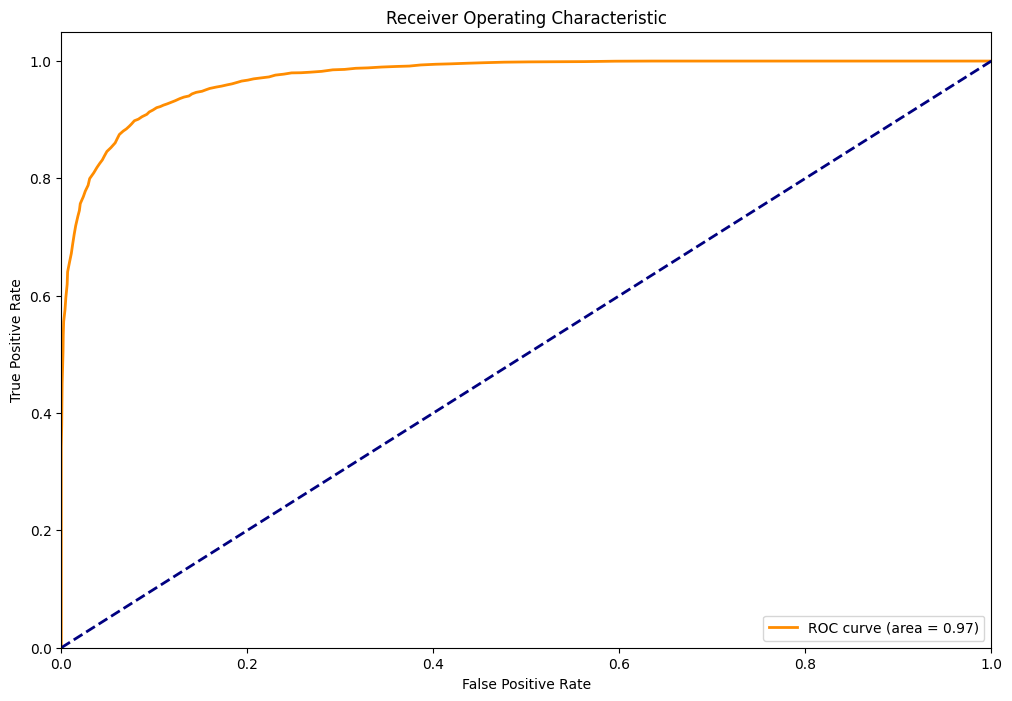

Model: xgb
Confusion Matrix:
[[3923  338]
 [ 367 3850]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.92      0.92      4261
           1       0.92      0.91      0.92      4217

    accuracy                           0.92      8478
   macro avg       0.92      0.92      0.92      8478
weighted avg       0.92      0.92      0.92      8478

ROC AUC Score: 0.9168236021463397


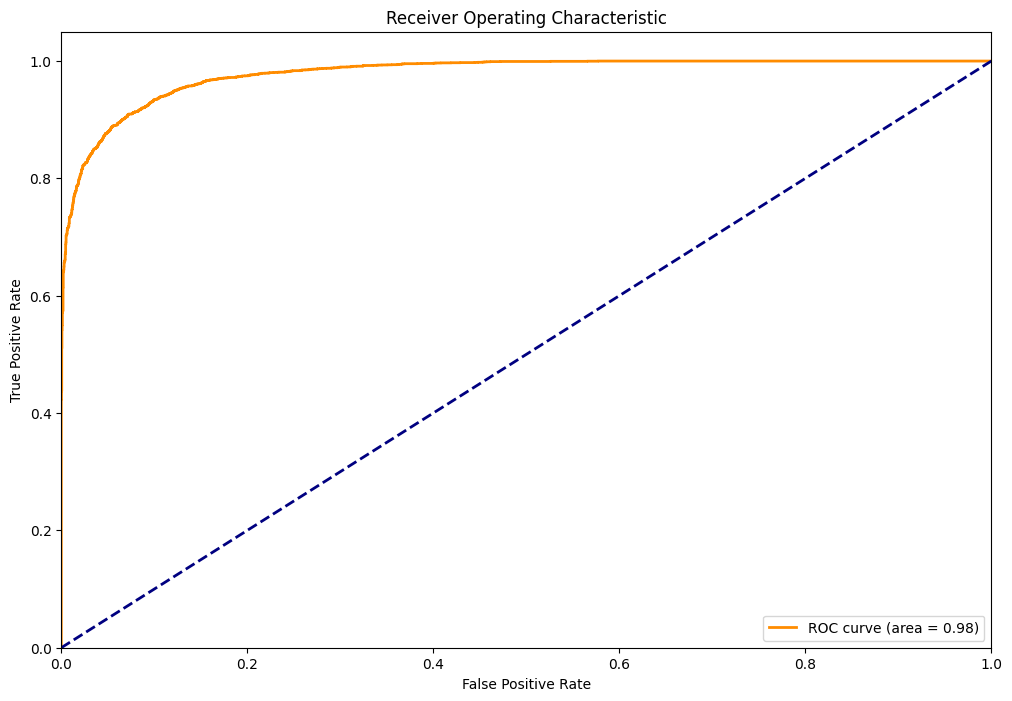

Model: stacked
Confusion Matrix:
[[3994  267]
 [ 458 3759]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      4261
           1       0.93      0.89      0.91      4217

    accuracy                           0.91      8478
   macro avg       0.92      0.91      0.91      8478
weighted avg       0.92      0.91      0.91      8478

ROC AUC Score: 0.9143653188608574


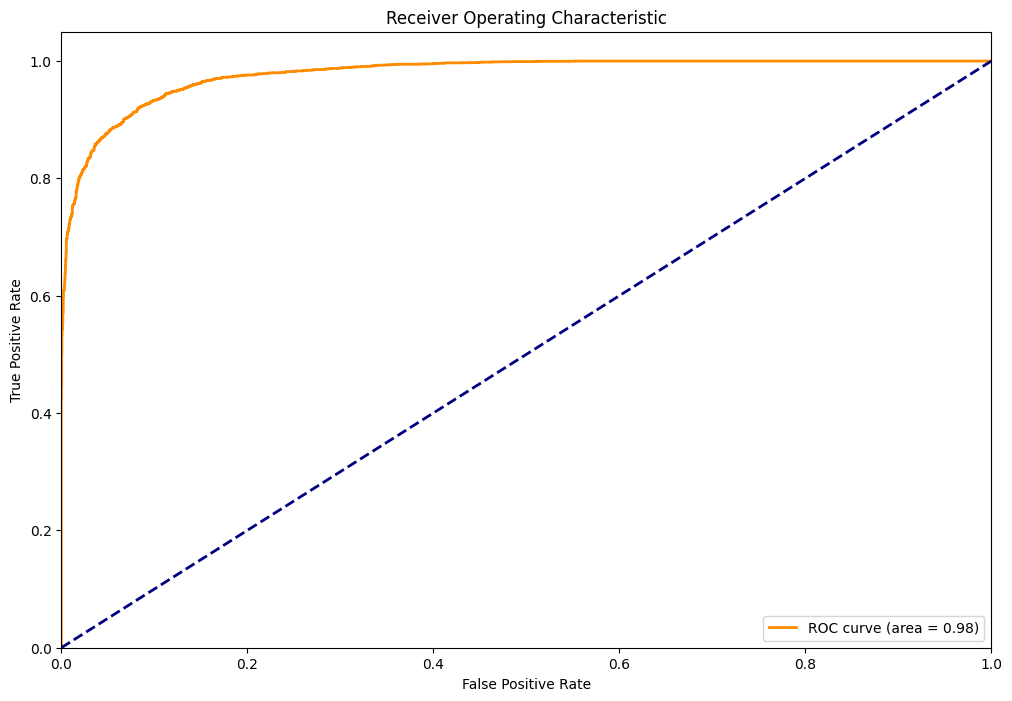

In [122]:
# print experiment results2

for model in model_type:
    print("Model:", model)
    clf = TimeSeriesClassifier()
    clf.fit(X_train4, y_train4, model=model)
    clf.evaluate(X_test4, y_test4, model=model)
    clf.plot_roc_curve(X_test4, y_test4, model=model)
    print("=====================================")

In [524]:
print(X_train.shape, y_train.shape)

(19867, 49) (19867,)


In [123]:
class FeaturePreprocessing:
    def __init__(self, window_size=5, lag_size=2):
        self.window_size = window_size
        self.lag_size = lag_size

    def preprocess_by_id(self, df):
        id = df['pond_code'].unique()
        X_train_all = []
        X_test_all = []
        y_train_all = []
        y_test_all = []
        for i in id:
            df2 = df[df['pond_code'] == i]
            X_train, X_test, y_train, y_test = self.preprocess(df2)
            X_train_all.append(X_train)
            X_test_all.append(X_test)
            y_train_all.append(y_train)
            y_test_all.append(y_test)
        X_train = pd.concat(X_train_all).fillna(0)
        X_test = pd.concat(X_test_all).fillna(0)
        y_train = pd.concat(y_train_all).fillna(0)
        y_test = pd.concat(y_test_all).fillna(0)
        return X_train, X_test, y_train, y_test

    def preprocess(self, data):
        data = self._add_rolling_features(data)
        data = self._add_lag_features(data)
        data = self._one_hot_encode(data)
        # drop rows with NaN values
        data['magn'] = (data['x']**2 + data['y']**2 + data['z']**2).apply(lambda x: math.sqrt(x))
        data = data.dropna()

        # split data into train and test
        X = data.drop(columns=['label', 'date', 'timestamp','x','y','z'], axis=1)
        y = data['label']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
        return X_train, X_test, y_train, y_test

    def _add_rolling_features(self, data):
        data['x_rolling_mean'] = data['x'].rolling(window=self.window_size).mean()
        data['x_rolling_std'] = data['x'].rolling(window=self.window_size).std()
        data['x_rolling_min'] = data['x'].rolling(window=self.window_size).min()
        data['x_rolling_max'] = data['x'].rolling(window=self.window_size).max()
        data['y_rolling_mean'] = data['y'].rolling(window=self.window_size).mean()
        data['y_rolling_std'] = data['y'].rolling(window=self.window_size).std()
        data['y_rolling_min'] = data['y'].rolling(window=self.window_size).min()
        data['y_rolling_max'] = data['y'].rolling(window=self.window_size).max()
        data['z_rolling_mean'] = data['z'].rolling(window=self.window_size).mean()
        data['z_rolling_std'] = data['z'].rolling(window=self.window_size).std()
        data['z_rolling_min'] = data['z'].rolling(window=self.window_size).min()
        data['z_rolling_max'] = data['z'].rolling(window=self.window_size).max()
        return data
    
    def _add_lag_features(self, data):
        for i in range(1, self.lag_size+1):
            data[f'x_lag_{i}'] = data['x'].shift(i)
            data[f'y_lag_{i}'] = data['y'].shift(i)
            data[f'z_lag_{i}'] = data['z'].shift(i)
        return data

    def _one_hot_encode(self, data):
        #data['label'] = data['label'].astype('category')
        data = pd.get_dummies(data, columns=['pond_code'])
        return data

In [132]:
preprocessor = FeaturePreprocessing(window_size=5, lag_size=10)
X_traina, X_testa, y_traina, y_testa = preprocessor.preprocess_by_id(df2)

In [133]:
X_traina.head()

x_rolling_mean  x_rolling_std  x_rolling_min  x_rolling_max  \
11990            -0.2       0.447214           -1.0            0.0   
11055            -0.2       1.788854           -2.0            2.0   
12895            -0.4       0.547723           -1.0            0.0   
9460             -5.6       8.734987          -20.0            2.0   
9083             -3.8       4.266146           -8.0            2.0   

       y_rolling_mean  y_rolling_std  y_rolling_min  y_rolling_max  \
11990           249.8       2.387467          247.0          253.0   
11055           248.4       1.140175          247.0          250.0   
12895           245.8       2.774887          243.0          250.0   
9460            228.4      15.388307          213.0          251.0   
9083            241.4       8.018728          233.0          253.0   

       z_rolling_mean  z_rolling_std  ...  y_lag_10  z_lag_10  pond_code_051  \
11990            35.8       1.303840  ...     250.0      38.0            1.0   
11055            36.4       1.949359  ...     247.0      35.0            1.0   
12895            38.2       2.280351  ...     247.0      36.0            1.0   
9460             22.8       8.105554  ...     217.0      15.0            1.0   
9083             42.0       5.244044  ...     245.0      43.0            1.0   

             magn  pond_code_101  pond_code_102  pond_code_103  pond_code_161  \
11990  250.746884            0.0            0.0            0.0            0.0   
11055  250.457581            0.0            0.0            0.0            0.0   
12895  252.580680            0.0            0.0            0.0            0.0   
9460   219.813557            0.0            0.0            0.0            0.0   
9083   239.879136            0.0            0.0            0.0            0.0   

       pond_code_162  pond_code_163  
11990            0.0            0.0  
11055            0.0            0.0  
12895            0.0            0.0  
9460             0.0            0.0  
9083             0.0            0.0  

[5 rows x 50 columns]

Model: rf
Confusion Matrix:
[[3830  431]
 [ 376 3862]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.90      0.90      4261
           1       0.90      0.91      0.91      4238

    accuracy                           0.91      8499
   macro avg       0.91      0.91      0.91      8499
weighted avg       0.91      0.91      0.91      8499

ROC AUC Score: 0.9050644701734699


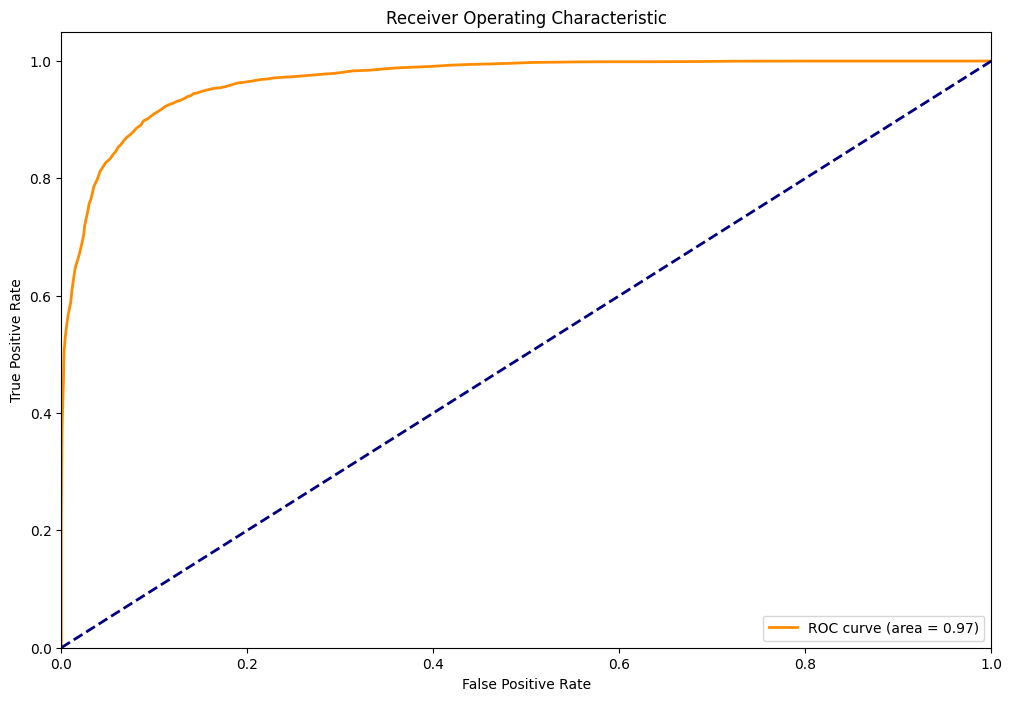

Model: xgb
Confusion Matrix:
[[3915  346]
 [ 412 3826]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      4261
           1       0.92      0.90      0.91      4238

    accuracy                           0.91      8499
   macro avg       0.91      0.91      0.91      8499
weighted avg       0.91      0.91      0.91      8499

ROC AUC Score: 0.9107913681813353


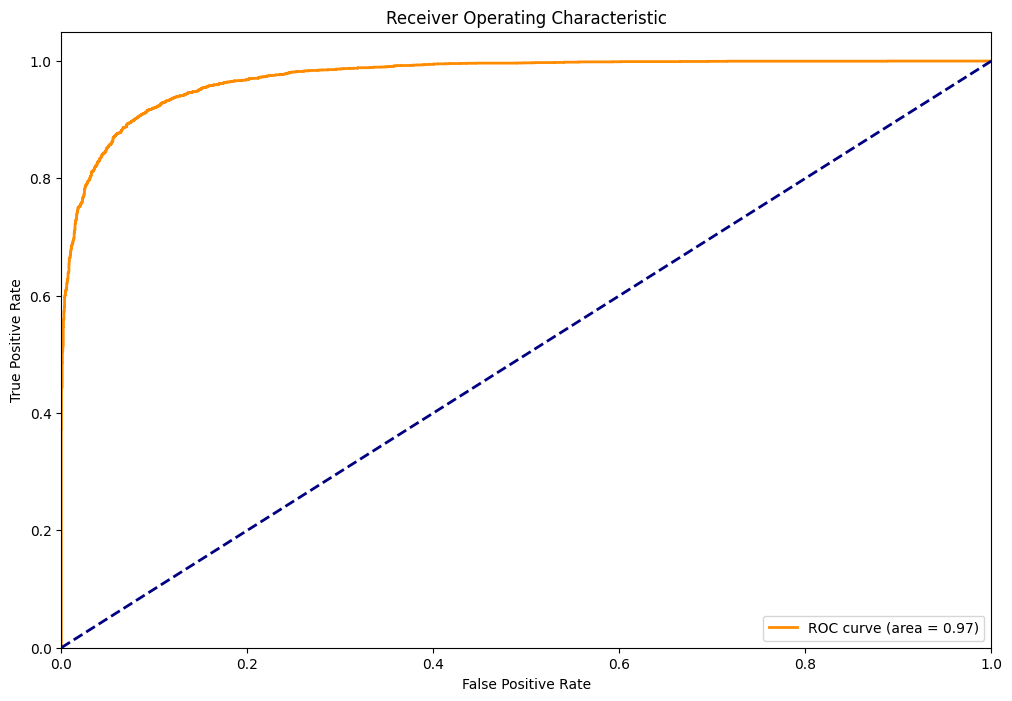

Model: stacked
Confusion Matrix:
[[3991  270]
 [ 524 3714]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      4261
           1       0.93      0.88      0.90      4238

    accuracy                           0.91      8499
   macro avg       0.91      0.91      0.91      8499
weighted avg       0.91      0.91      0.91      8499

ROC AUC Score: 0.9064956824404403


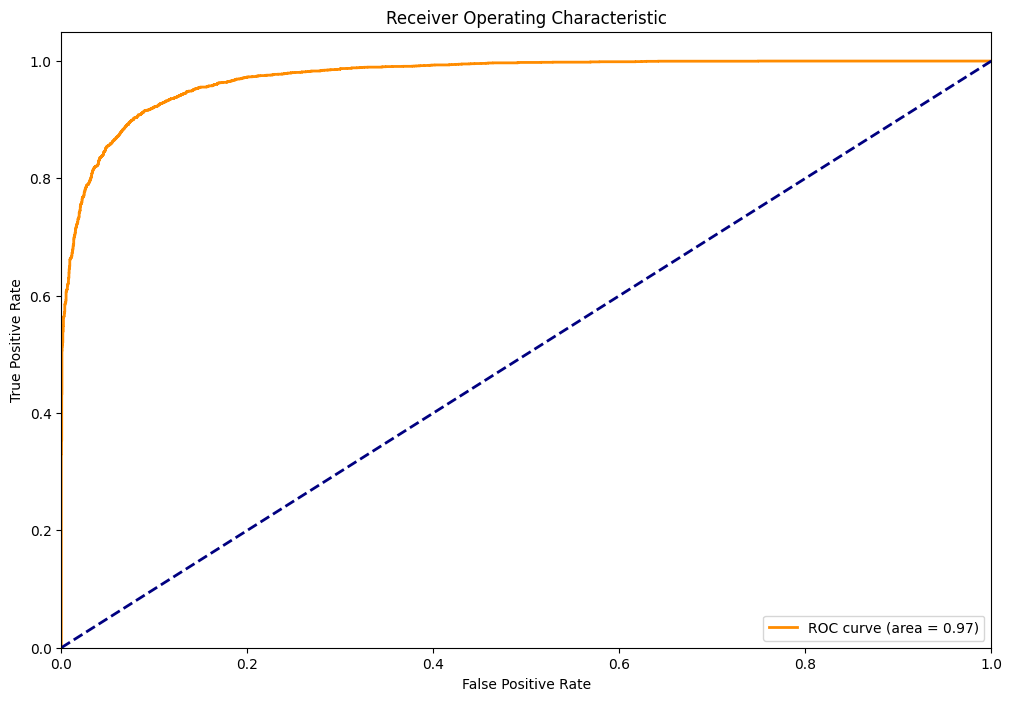

In [134]:
# print experiment results2

for model in model_type:
    print("Model:", model)
    clf = TimeSeriesClassifier()
    clf.fit(X_traina, y_traina, model=model)
    clf.evaluate(X_testa, y_testa, model=model)
    clf.plot_roc_curve(X_testa, y_testa, model=model)
    print("=====================================")

## Experiment 4

In [136]:
class FeaturePreprocessing2:
    def __init__(self, window_size=5, lag_size=2):
        self.window_size = window_size
        self.lag_size = lag_size

    def preprocess(self, data):
        data = self._add_rolling_features(data)
        data = self._add_lag_features(data)
        data = self._one_hot_encode(data)
        # drop rows with NaN values
        data['magn'] = (data['x']**2 + data['y']**2 + data['z']**2).apply(lambda x: math.sqrt(x))
        data = data.dropna()

        # split data into train and test
        X = data.drop(columns=['label', 'date', 'timestamp','x','y','z'], axis=1)
        y = data['label']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
        return X_train, X_test, y_train, y_test

    def _add_rolling_features(self, data):
        data['x_rolling_mean'] = data['x'].rolling(window=self.window_size).mean()
        data['x_rolling_std'] = data['x'].rolling(window=self.window_size).std()
        data['x_rolling_min'] = data['x'].rolling(window=self.window_size).min()
        data['x_rolling_max'] = data['x'].rolling(window=self.window_size).max()
        data['y_rolling_mean'] = data['y'].rolling(window=self.window_size).mean()
        data['y_rolling_std'] = data['y'].rolling(window=self.window_size).std()
        data['y_rolling_min'] = data['y'].rolling(window=self.window_size).min()
        data['y_rolling_max'] = data['y'].rolling(window=self.window_size).max()
        data['z_rolling_mean'] = data['z'].rolling(window=self.window_size).mean()
        data['z_rolling_std'] = data['z'].rolling(window=self.window_size).std()
        data['z_rolling_min'] = data['z'].rolling(window=self.window_size).min()
        data['z_rolling_max'] = data['z'].rolling(window=self.window_size).max()
        return data
    
    def _add_lag_features(self, data):
        for i in range(1, self.lag_size+1):
            data[f'x_lag_{i}'] = data['x'].shift(i)
            data[f'y_lag_{i}'] = data['y'].shift(i)
            data[f'z_lag_{i}'] = data['z'].shift(i)
        return data

    def _one_hot_encode(self, data):
        #data['label'] = data['label'].astype('category')
        data = pd.get_dummies(data, columns=['pond_code'])
        return data

#### XGBOOST

051
Confusion Matrix:
[[656 124]
 [ 93 681]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       780
           1       0.85      0.88      0.86       774

    accuracy                           0.86      1554
   macro avg       0.86      0.86      0.86      1554
weighted avg       0.86      0.86      0.86      1554

ROC AUC Score: 0.8604353011329755


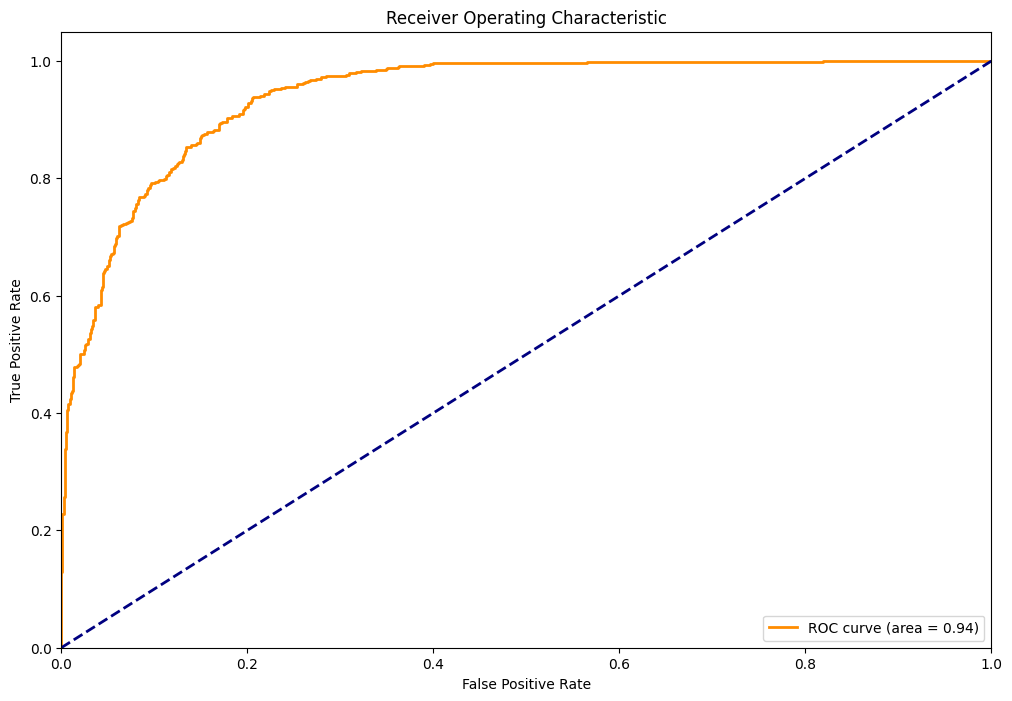

------------------------
101
Confusion Matrix:
[[657  30]
 [ 29 651]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       687
           1       0.96      0.96      0.96       680

    accuracy                           0.96      1367
   macro avg       0.96      0.96      0.96      1367
weighted avg       0.96      0.96      0.96      1367

ROC AUC Score: 0.9568424094528641


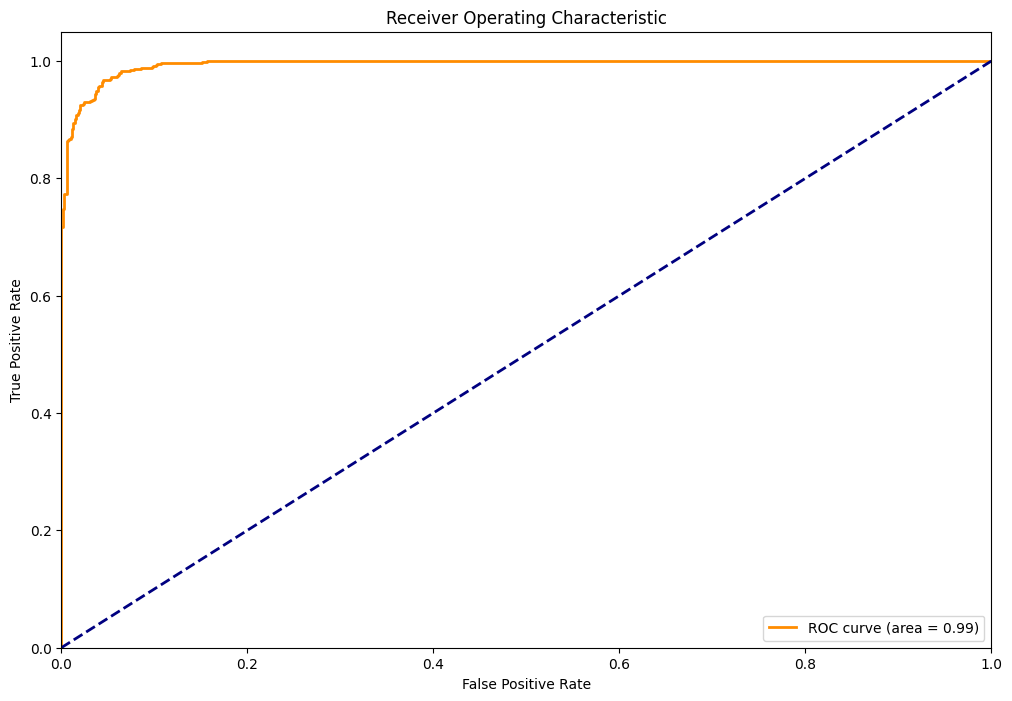

------------------------
102
Confusion Matrix:
[[540  22]
 [ 34 522]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       562
           1       0.96      0.94      0.95       556

    accuracy                           0.95      1118
   macro avg       0.95      0.95      0.95      1118
weighted avg       0.95      0.95      0.95      1118

ROC AUC Score: 0.949851506695


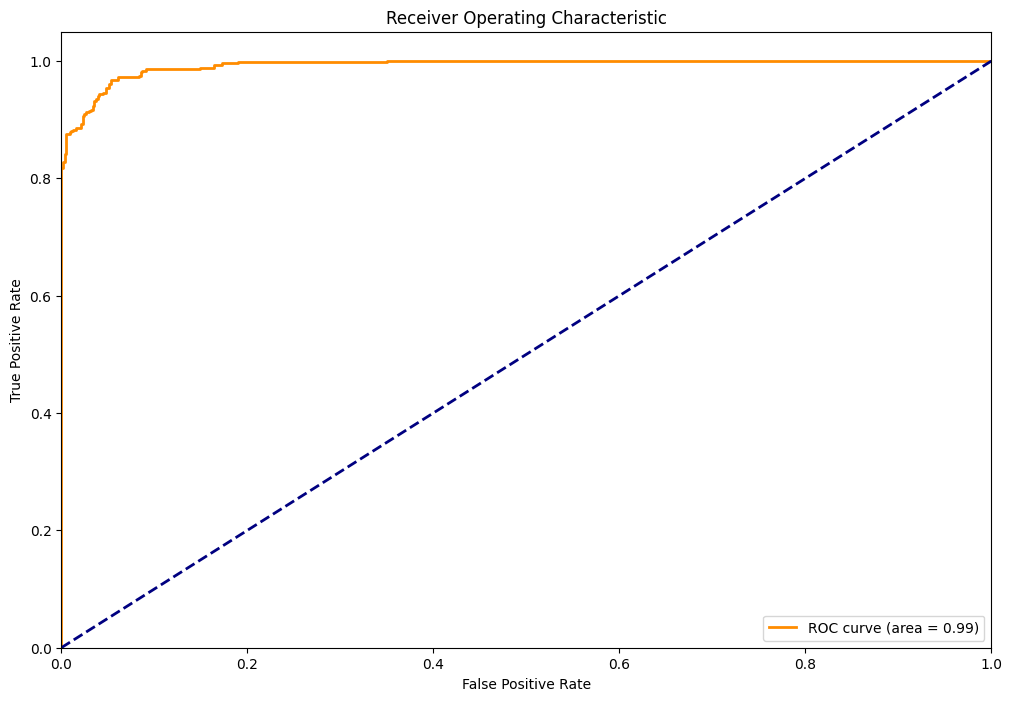

------------------------
103
Confusion Matrix:
[[782  45]
 [ 96 725]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       827
           1       0.94      0.88      0.91       821

    accuracy                           0.91      1648
   macro avg       0.92      0.91      0.91      1648
weighted avg       0.92      0.91      0.91      1648

ROC AUC Score: 0.914327942300583


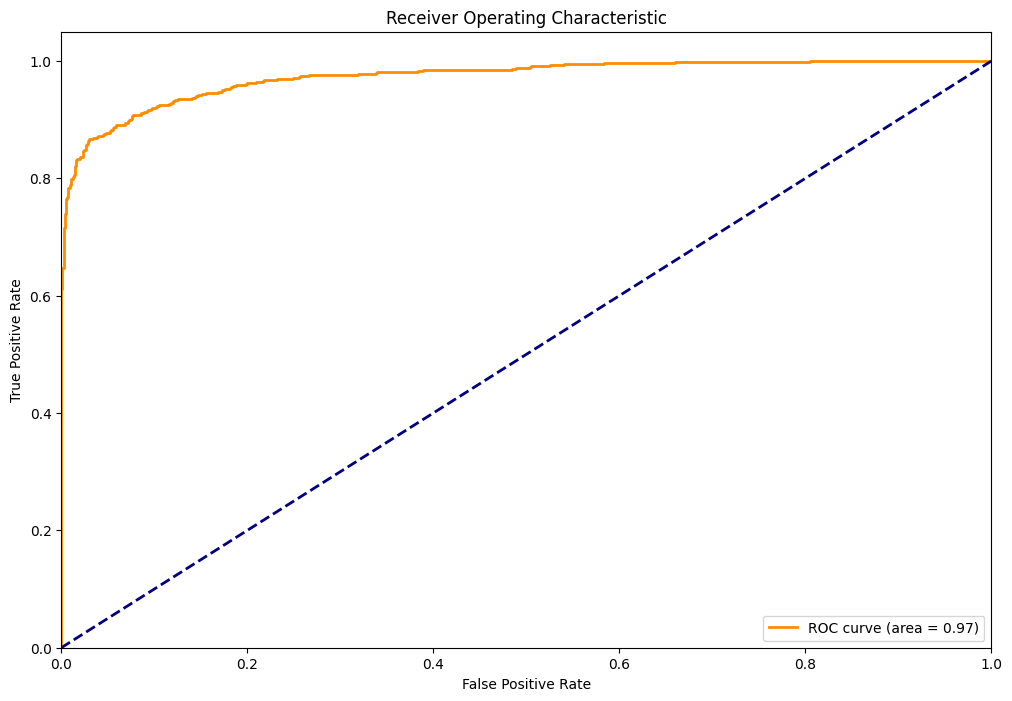

------------------------
161
Confusion Matrix:
[[539   7]
 [  1 539]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       546
           1       0.99      1.00      0.99       540

    accuracy                           0.99      1086
   macro avg       0.99      0.99      0.99      1086
weighted avg       0.99      0.99      0.99      1086

ROC AUC Score: 0.9926638176638176


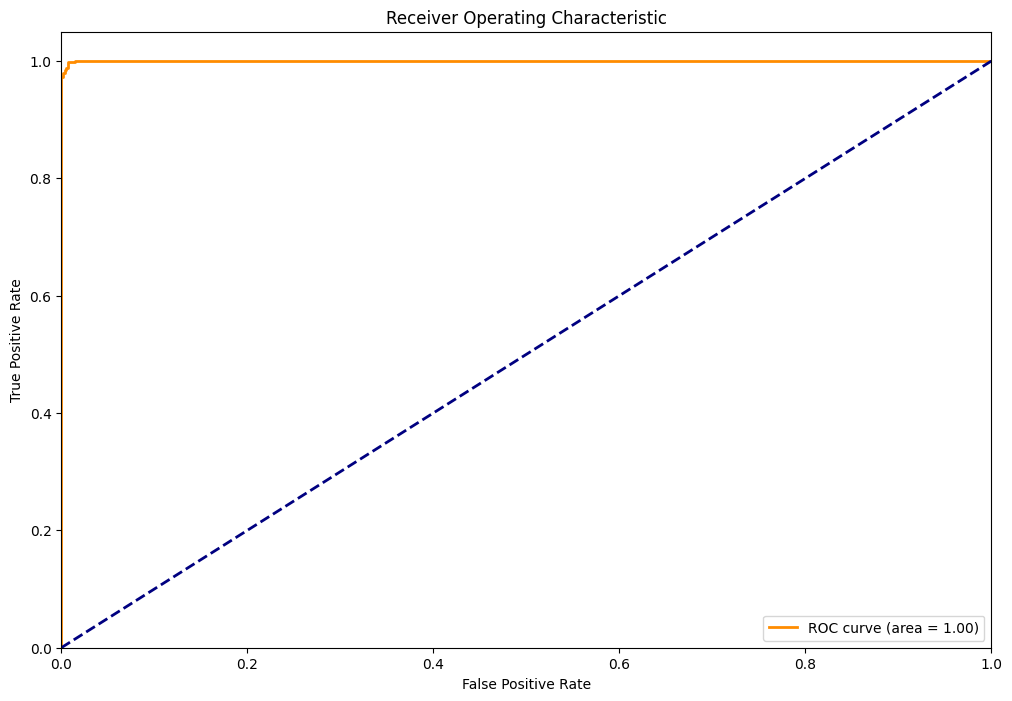

------------------------
162
Confusion Matrix:
[[420  17]
 [ 15 416]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       437
           1       0.96      0.97      0.96       431

    accuracy                           0.96       868
   macro avg       0.96      0.96      0.96       868
weighted avg       0.96      0.96      0.96       868

ROC AUC Score: 0.9631478069732993


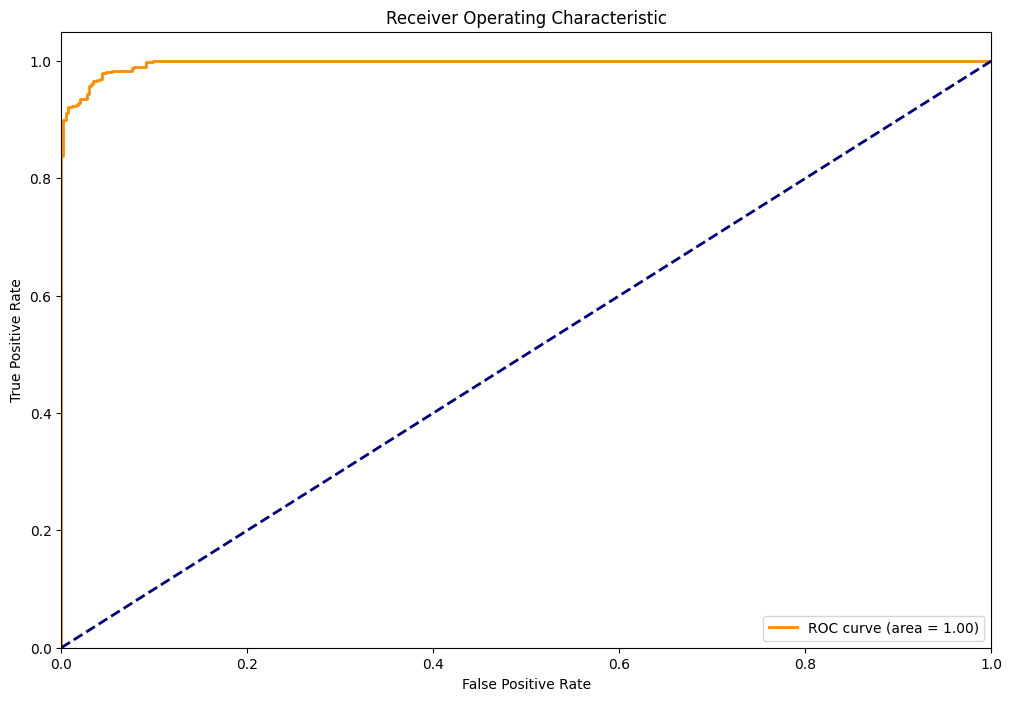

------------------------
163
Confusion Matrix:
[[407  15]
 [  8 407]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       422
           1       0.96      0.98      0.97       415

    accuracy                           0.97       837
   macro avg       0.97      0.97      0.97       837
weighted avg       0.97      0.97      0.97       837

ROC AUC Score: 0.9725889339347913


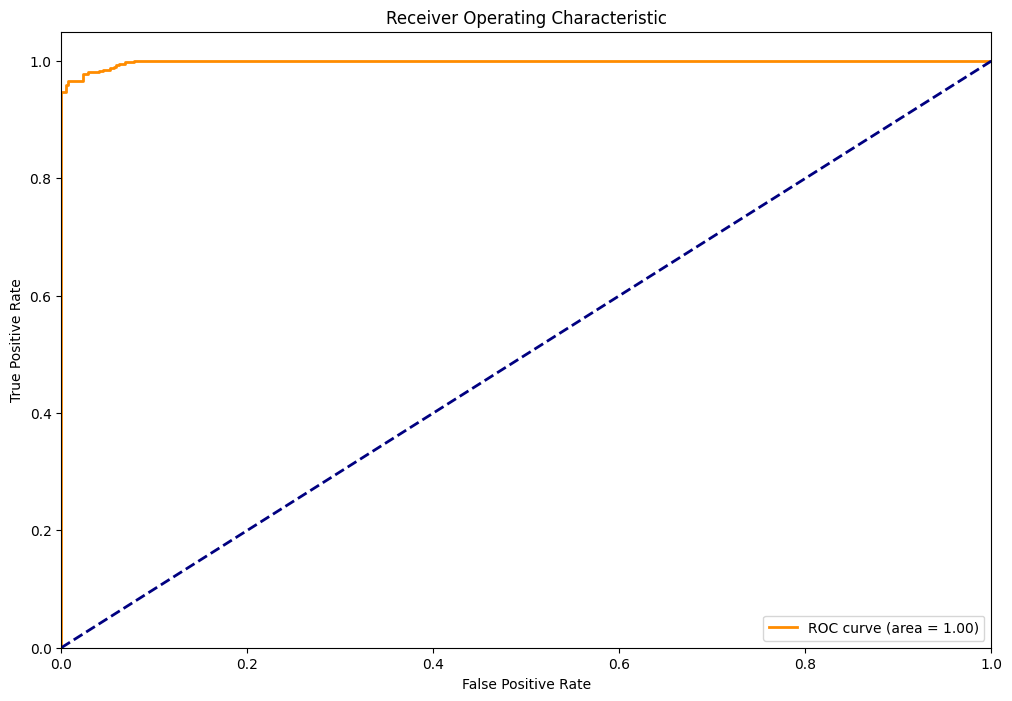

------------------------


In [139]:
# separate data based on pond_code

model_type ='xgb'
code = df.pond_code.unique().tolist()
df_new = df.iloc[:,:7]
for i in code:
    print(i)
    df_temp = df2[df2['pond_code'] == i]
    prep = FeaturePreprocessing2(window_size=5, lag_size= 20)
    X_train, X_test, y_train, y_test = prep.preprocess(df_temp)
    clf = TimeSeriesClassifier()
    clf.fit(X_train, y_train, model=model_type)
    clf.predict(X_test, model=model_type)
    clf.evaluate(X_test, y_test, model=model_type)
    clf.plot_roc_curve(X_test, y_test, model=model_type)
    print('------------------------')